In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'monkeypox-dataset-daily-updated:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2215778%2F4240231%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T085534Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5be52bb1f703c227b4056ddc42a92a91c556b378c29fd53483ae945264b94357891879abe06b67745cf56f5c4b6b6921a679757ec6a5324d9d8db345b64558ee46a3c60dfad0cde9e14143873f360d25e14229b402e63e9a4d3243b1591ceb9814a0f432beafcefeca074353713fb1018ba078521bf017ab631d224bbdfbb4ecfafc7ad99789cd9379257107a7421641ee3a8bf0f949c7c3bc14332818ff1ec0f1a89f75761da28fc1da6dd992b486b20f700e7d6e8ba23fa4cfca5badd8056f77df9c6597281e12aed57b77b7d90d8ab2263e64147af2aee78b1f5ba78bdd41625773b7e6f855cd47f1786a53592ac7cf79b592bf499da9c759362aee457c83'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 46579 bytes downloaded
Downloaded and uncompressed: monkeypox-dataset-daily-updated
Data source import complete.


# Data Analysis for Public Health
### Professor MAUGERI ANDREA GIUSEPPE
**Harsh Mehta - 1000055155**

# Context

## What is Monkeypox Virus ?
Monkeypox is a rare disease caused by infection with the monkeypox virus. Monkeypox virus is part of the same family of viruses as variola virus, the virus that causes smallpox. Monkeypox symptoms are similar to smallpox symptoms, but milder, and monkeypox is rarely fatal. Monkeypox is not related to chickenpox.

Monkeypox was discovered in 1958 when two outbreaks of a pox-like disease occurred in colonies of monkeys kept for research. Despite being named “monkeypox,” the source of the disease remains unknown. However, African rodents and non-human primates (like monkeys) might harbor the virus and infect people.

The first human case of monkeypox was recorded in 1970. Prior to the 2022 outbreak, monkeypox had been reported in people in several central and western African countries. Previously, almost all monkeypox cases in people outside of Africa were linked to international travel to countries where the disease commonly occurs or through imported animals. These cases occurred on multiple continents.

## Data Source:
- [Globaldothealth Github](https://github.com/globaldothealth)

## Importing the Libraries



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
%config InlineBackend.figure_format ='retina'

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

## This dataset contains a tally of confirmed and suspected cases in all the countries.

In [ ]:
mp_cases_worldwide = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Monkey_Pox_Cases_Worldwide.csv')
mp_cases_worldwide.head()

Country  Confirmed_Cases  Suspected_Cases  Hospitalized  \
0        England           3412.0              0.0           5.0   
1       Portugal            908.0              0.0           0.0   
2          Spain           7083.0              0.0          13.0   
3  United States          24403.0              0.0           4.0   
4         Canada           1388.0             12.0           1.0   

   Travel_History_Yes  Travel_History_No  
0                 2.0                7.0  
1                 0.0               34.0  
2                 2.0                0.0  
3                41.0               11.0  
4                 5.0                0.0

In [ ]:
mp_cases_worldwide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             129 non-null    object 
 1   Confirmed_Cases     129 non-null    float64
 2   Suspected_Cases     129 non-null    float64
 3   Hospitalized        129 non-null    float64
 4   Travel_History_Yes  129 non-null    float64
 5   Travel_History_No   129 non-null    float64
dtypes: float64(5), object(1)
memory usage: 6.2+ KB


## This dataset contains the timeline for confirmed cases w.r.t. date time, it also contains some other details on every case that is being reported.

In [ ]:
mp_cases_detected = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Worldwide_Case_Detection_Timeline.csv')
mp_cases_detected.head()

Date_confirmation   Country City   Age Gender Symptoms  \
0        2022-01-31   Nigeria  NaN   NaN    NaN      NaN   
1        2022-01-31   Nigeria  NaN   NaN    NaN      NaN   
2        2022-01-31   Nigeria  NaN   NaN    NaN      NaN   
3        2022-02-17  Cameroon  NaN  0-39    NaN      NaN   
4        2022-02-17  Cameroon  NaN  0-39    NaN      NaN   

  Hospitalised (Y/N/NA) Isolated (Y/N/NA) Travel_history (Y/N/NA)  
0                   NaN               NaN                     NaN  
1                   NaN               NaN                     NaN  
2                   NaN               NaN                     NaN  
3                   NaN               NaN                     NaN  
4                   NaN               NaN                     NaN

- We can observe duplicate rows

- So before we proceed for further analysis, its necessary to remove those duplicate rows.

#### Shape of dataset before removing duplicates

In [ ]:
mp_cases_detected.shape

(65546, 9)

### Removing Duplicates

In [ ]:
mp_cases_detected = mp_cases_detected.drop_duplicates()

#### Shape of dataset after removing duplicates

In [ ]:
mp_cases_detected.shape

(2250, 9)

In [ ]:
mp_cases_detected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 0 to 65463
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Date_confirmation        2250 non-null   object
 1   Country                  2250 non-null   object
 2   City                     410 non-null    object
 3   Age                      686 non-null    object
 4   Gender                   733 non-null    object
 5   Symptoms                 122 non-null    object
 6   Hospitalised (Y/N/NA)    205 non-null    object
 7   Isolated (Y/N/NA)        326 non-null    object
 8   Travel_history (Y/N/NA)  290 non-null    object
dtypes: object(9)
memory usage: 175.8+ KB


## This dataset contains the daily number of confirmed cases for all the countries where the virus has entered.

In [ ]:
mp_cases_confirmed = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Daily_Country_Wise_Confirmed_Cases.csv')
mp_cases_confirmed.head()

Country  2022-01-31  2022-02-17  2022-02-28  2022-03-04  \
0                   Nigeria           3           0           1           0   
1                  Cameroon           0           3           0           0   
2  Central African Republic           0           0           0           2   
3         Republic of Congo           0           0           0           0   
4                   England           0           0           0           0   

   2022-03-31  2022-04-10  2022-04-12  2022-04-30  2022-05-06  ...  \
0           6           0           0           5           0  ...   
1           0           0           0           0           0  ...   
2           0           4           0           0           0  ...   
3           0           0           2           0           0  ...   
4           0           0           0           0           1  ...   

   2022-09-13  2022-09-14  2022-09-15  2022-09-16  2022-09-17  2022-09-18  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   2022-09-19  2022-09-20  2022-09-21  2022-09-22  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0          29           0           0  

[5 rows x 142 columns]

In [ ]:
mp_cases_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Columns: 142 entries, Country to 2022-09-22
dtypes: int64(141), object(1)
memory usage: 124.4+ KB


## Monkey Pox affected countries worldwide.

In [ ]:
def plot_map(df,col, title):
    df = df[df[col]>0]
    fig = px.choropleth(df, locations="Country", locationmode='country names',
                  color=col, hover_name="Country",
                  title=title, hover_data=[col], color_continuous_scale="Plasma")
    fig.show()

In [ ]:
def treemap_plot(col):
    fig = px.treemap(mp_cases_worldwide, path=["Country"], values=col, height=700,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
    fig.data[0].textinfo = 'label+text+value'
    fig.show()

In [ ]:
plot_map(mp_cases_worldwide, 'Confirmed_Cases', 'Confirmed Cases by Country')

In [ ]:
treemap_plot('Confirmed_Cases')

#### Observations:
- United States has the most number of Confirmed cases.
- Behind United States, its Spain where cases have been increasing at an alarming rate.

In [ ]:
plot_map(mp_cases_worldwide, 'Suspected_Cases', 'Suspected Cases by Country')

In [ ]:
treemap_plot('Suspected_Cases')

#### Observations:
- The countries like Democratic Republic of The Congo and Nigeria are two countries with most suspected monkey cases.
- It seems the hot conditions of African continent is also aiding the virus spread.

In [ ]:
plot_map(mp_cases_worldwide, 'Travel_History_Yes', 'Travel History Data by Country')

In [ ]:
treemap_plot('Travel_History_Yes')

#### Observations:
- These are mostly tourist countries at top which are affected by virus the most. United States being affected the most.

In [ ]:
plot_map(mp_cases_worldwide, 'Travel_History_No', 'No Travel History Data by Country')

In [ ]:
treemap_plot('Travel_History_No')

#### Observations:
- Portugal is affected by virus the most though there is no Travel History.

In [ ]:
fig = px.bar(mp_cases_worldwide,x='Country', y='Hospitalized')
fig.show()

NameError: name 'px' is not defined

#### Observations:
- Italy and Germany being affected by virus most, have the most number of hospitalized patients.

## Symptoms detected in Monkey Pox patients.


In [ ]:
mp_cases_detected['Symptoms'].unique()

array([nan, 'rash', 'vesicular rash', 'skin lesions, ulcerative lesions',
       'ulcerative lesions', 'perianal papules; inguinal adenopathy',
       'Slight swallowing difficulties and an elevated temperature',
       'genital ulcers', 'lesions', 'genital rash', 'fever, rash',
       'oral and genital ulcers, fever', 'skin lesions', 'fever, lesions',
       'fever, cough, skin lesions', 'blisters', 'pustules, fever',
       'blisters, high fever', 'genital ulcer lesions',
       'fever, muscle pain, rash', 'Fever, skin rashes',
       'Fever, chills, fatigue, headache, skin lesions',
       'cough, chills, muscle pain, pustule-like lesions',
       'skin lesions, fever', 'fever; myalgia',
       'headache, muscle pain, back pain, vasicular rashes',
       'skin lesions, headaches, enlarged lymph nodes, fever',
       'rash on the skin', 'papules, itching',
       'Spots on skin, vesicuated lesions, skin scabs',
       'headache, fever, skin rashes', 'fever; rash',
       'fever, swol

In [ ]:
mp_cases_detected['Symptoms'] = mp_cases_detected['Symptoms'].fillna('NA')
mp_cases_detected['Symptoms'] = mp_cases_detected['Symptoms'].str.lower()
symptoms_list = []
for symptom in mp_cases_detected['Symptoms'].values:
    if symptom not in symptoms_list:
        symptoms_list.append(symptom)

#### Observations:
- Several entries of **Symptoms** column contain multiple symptoms, which needs to be separated and kept individually.

In [ ]:
def unique_symptoms(symptoms):
    all_symptoms = []
    for i in symptoms:
        if ',' in i:
            values = i.split(',')
            for value in values:
                all_symptoms.append(value)
        if ' and' in i:
            values = i.split('and')
            for value in values:
                all_symptoms.append(value)
        if ';' in i:
            values = i.split(';')
            for value in values:
                all_symptoms.append(value)
        if ',' not in i and 'and' not in i and ';' not in i:
            all_symptoms.append(i)
    return all_symptoms

filtered_symptoms = unique_symptoms(symptoms_list)
total_symptoms = ''
for symptom in filtered_symptoms:
    total_symptoms+=symptom

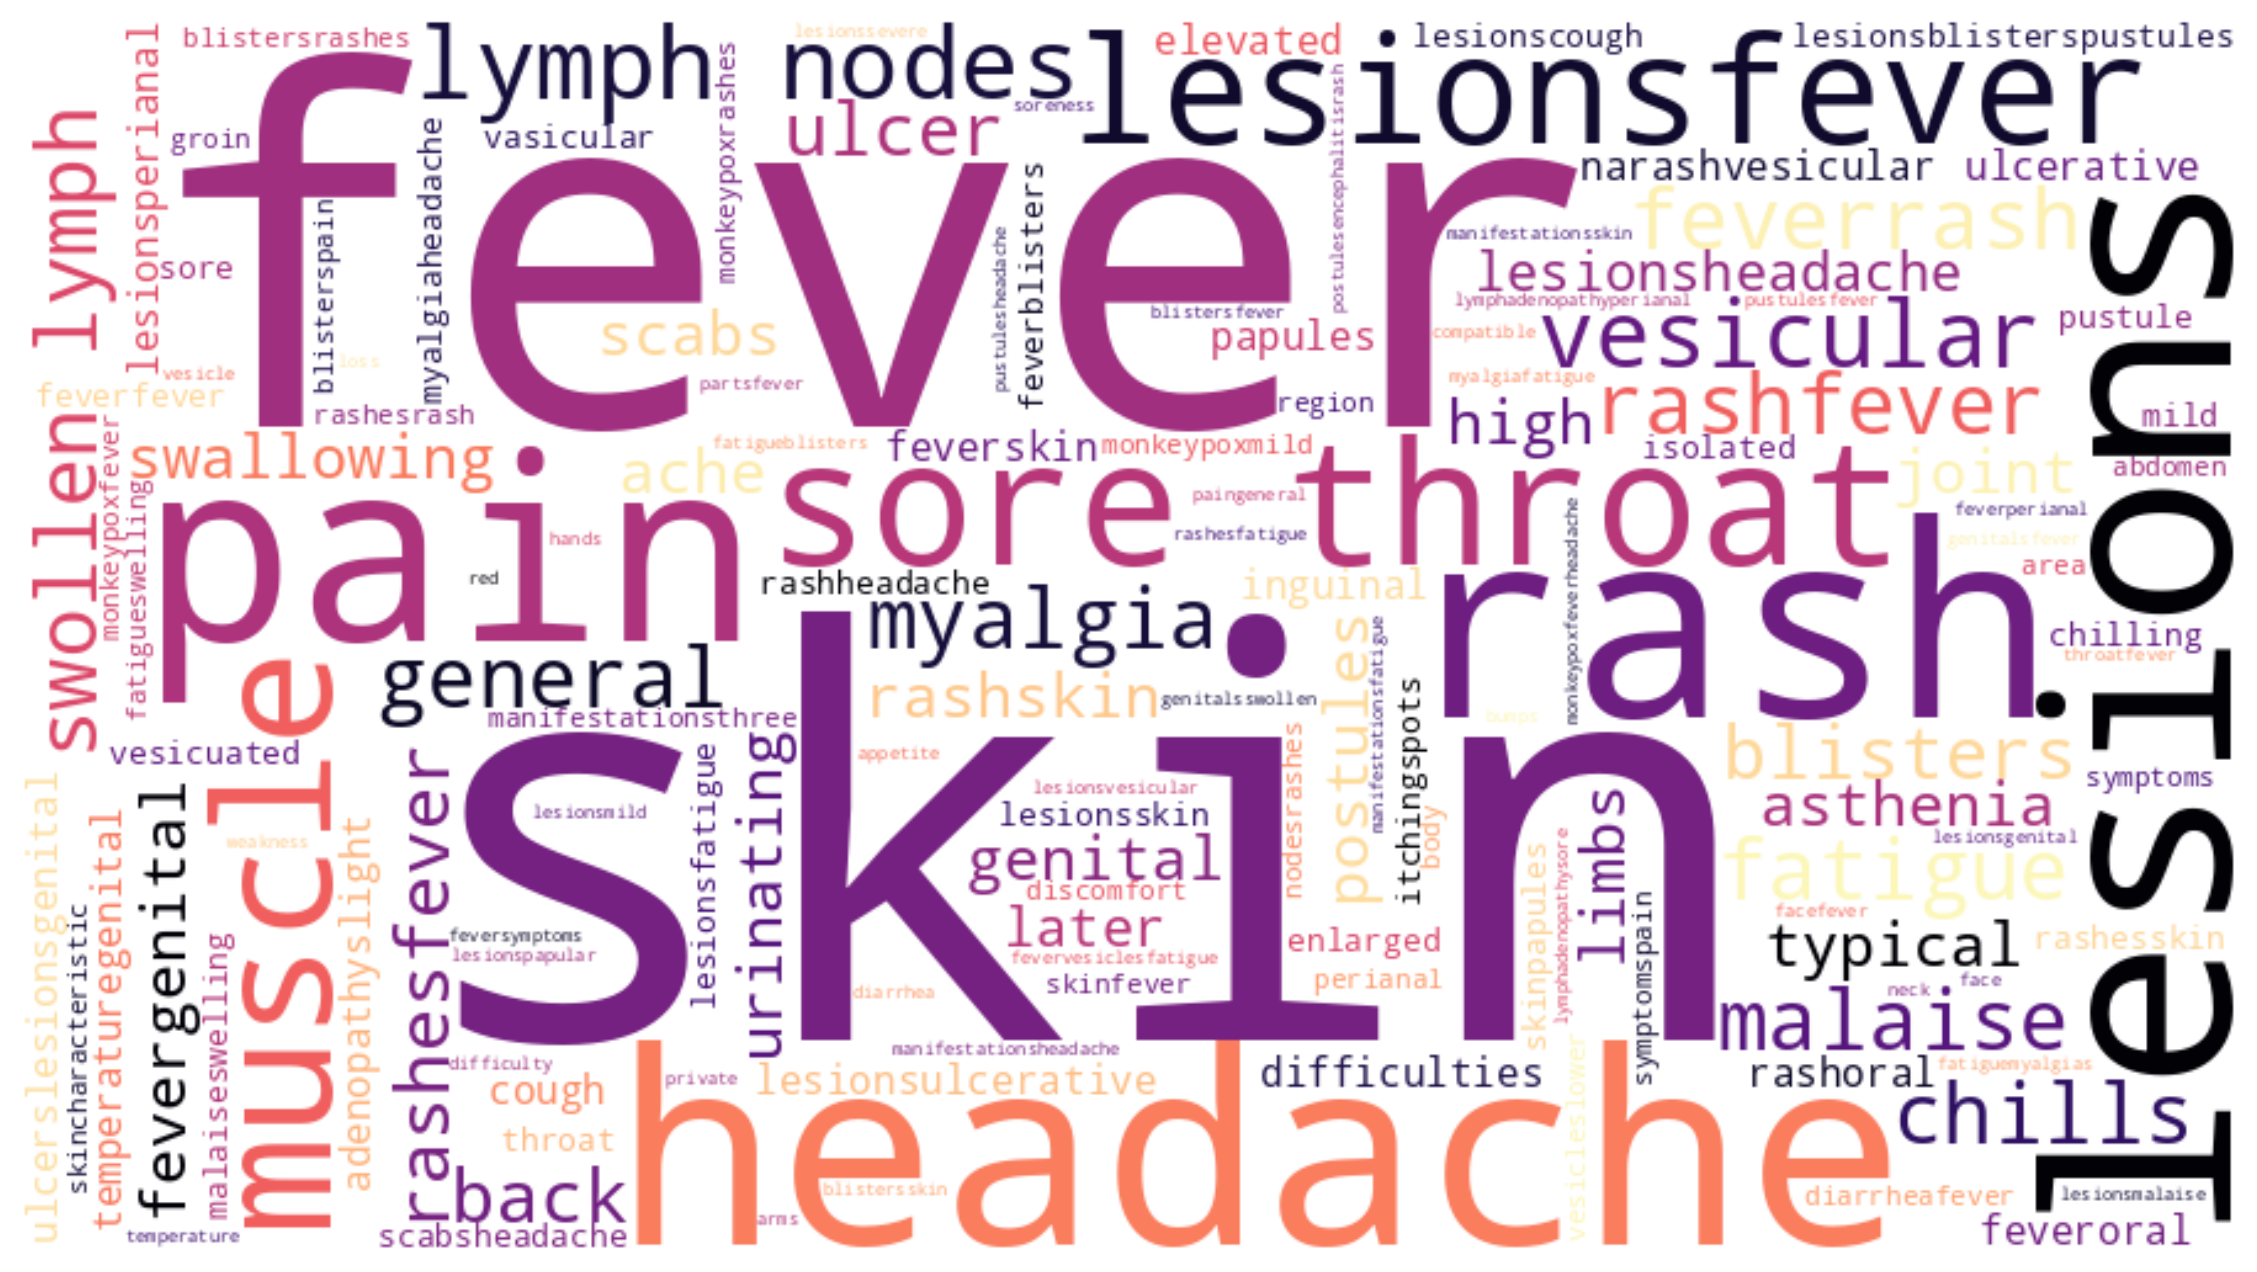

In [ ]:
wordcloud = WordCloud(background_color="white",
                      max_words=300,
                      width=900,
                      height=500,
                      colormap="magma"
                     ).generate(total_symptoms)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observations:
- The most common symptoms for monkey pox are found to be related to skin, lesions, headache and fever.

## How Monkey Pox affected Gender wise?

In [ ]:
mp_cases_detected.Gender.unique()

array([nan, 'male', 'female', 'male ', 'female ', 'Male'], dtype=object)

#### Observations:
- Clearly the **Gender** variable contains repeated genders with some extra spaces which needs to be fixed.

In [ ]:
mp_cases_detected['Gender'] = mp_cases_detected['Gender'].str.strip()
mp_cases_detected['Gender'] = mp_cases_detected['Gender'].str.lower()
mp_cases_detected['Gender'] = mp_cases_detected['Gender'].replace(np.nan,'NA')

In [ ]:
mp_cases_detected.Gender.unique()

array(['NA', 'male', 'female'], dtype=object)

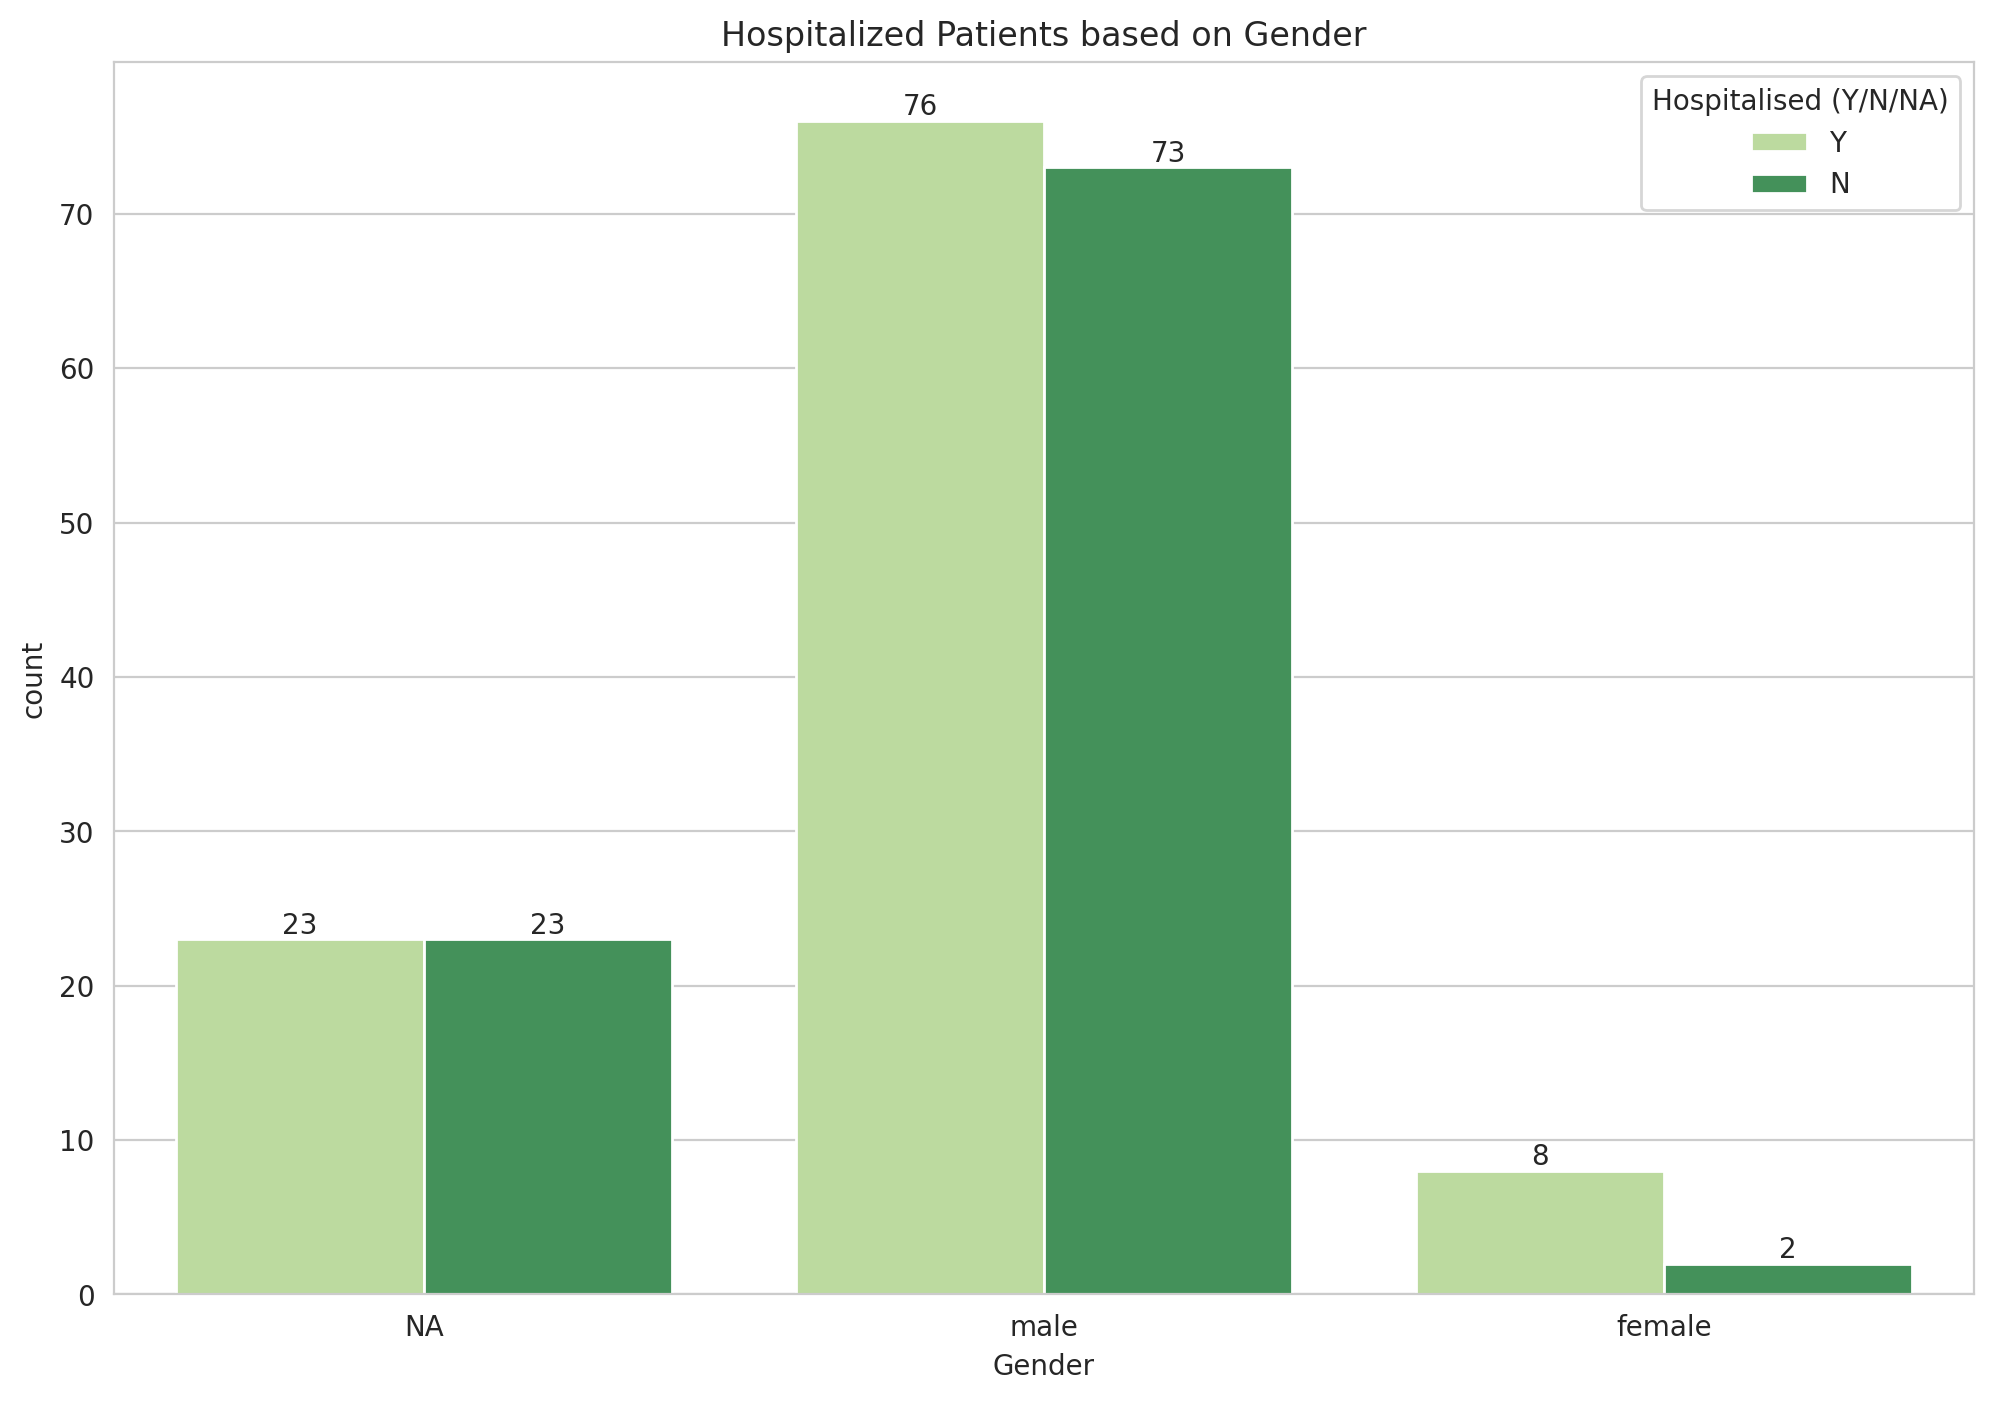

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='Gender',hue='Hospitalised (Y/N/NA)',data=mp_cases_detected, palette = 'YlGn')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Hospitalized Patients based on Gender')
plt.show()

#### Observations:
- It seems Male gender is affected and hospitalized the most.


## Hospitalised Cases in different Countries.

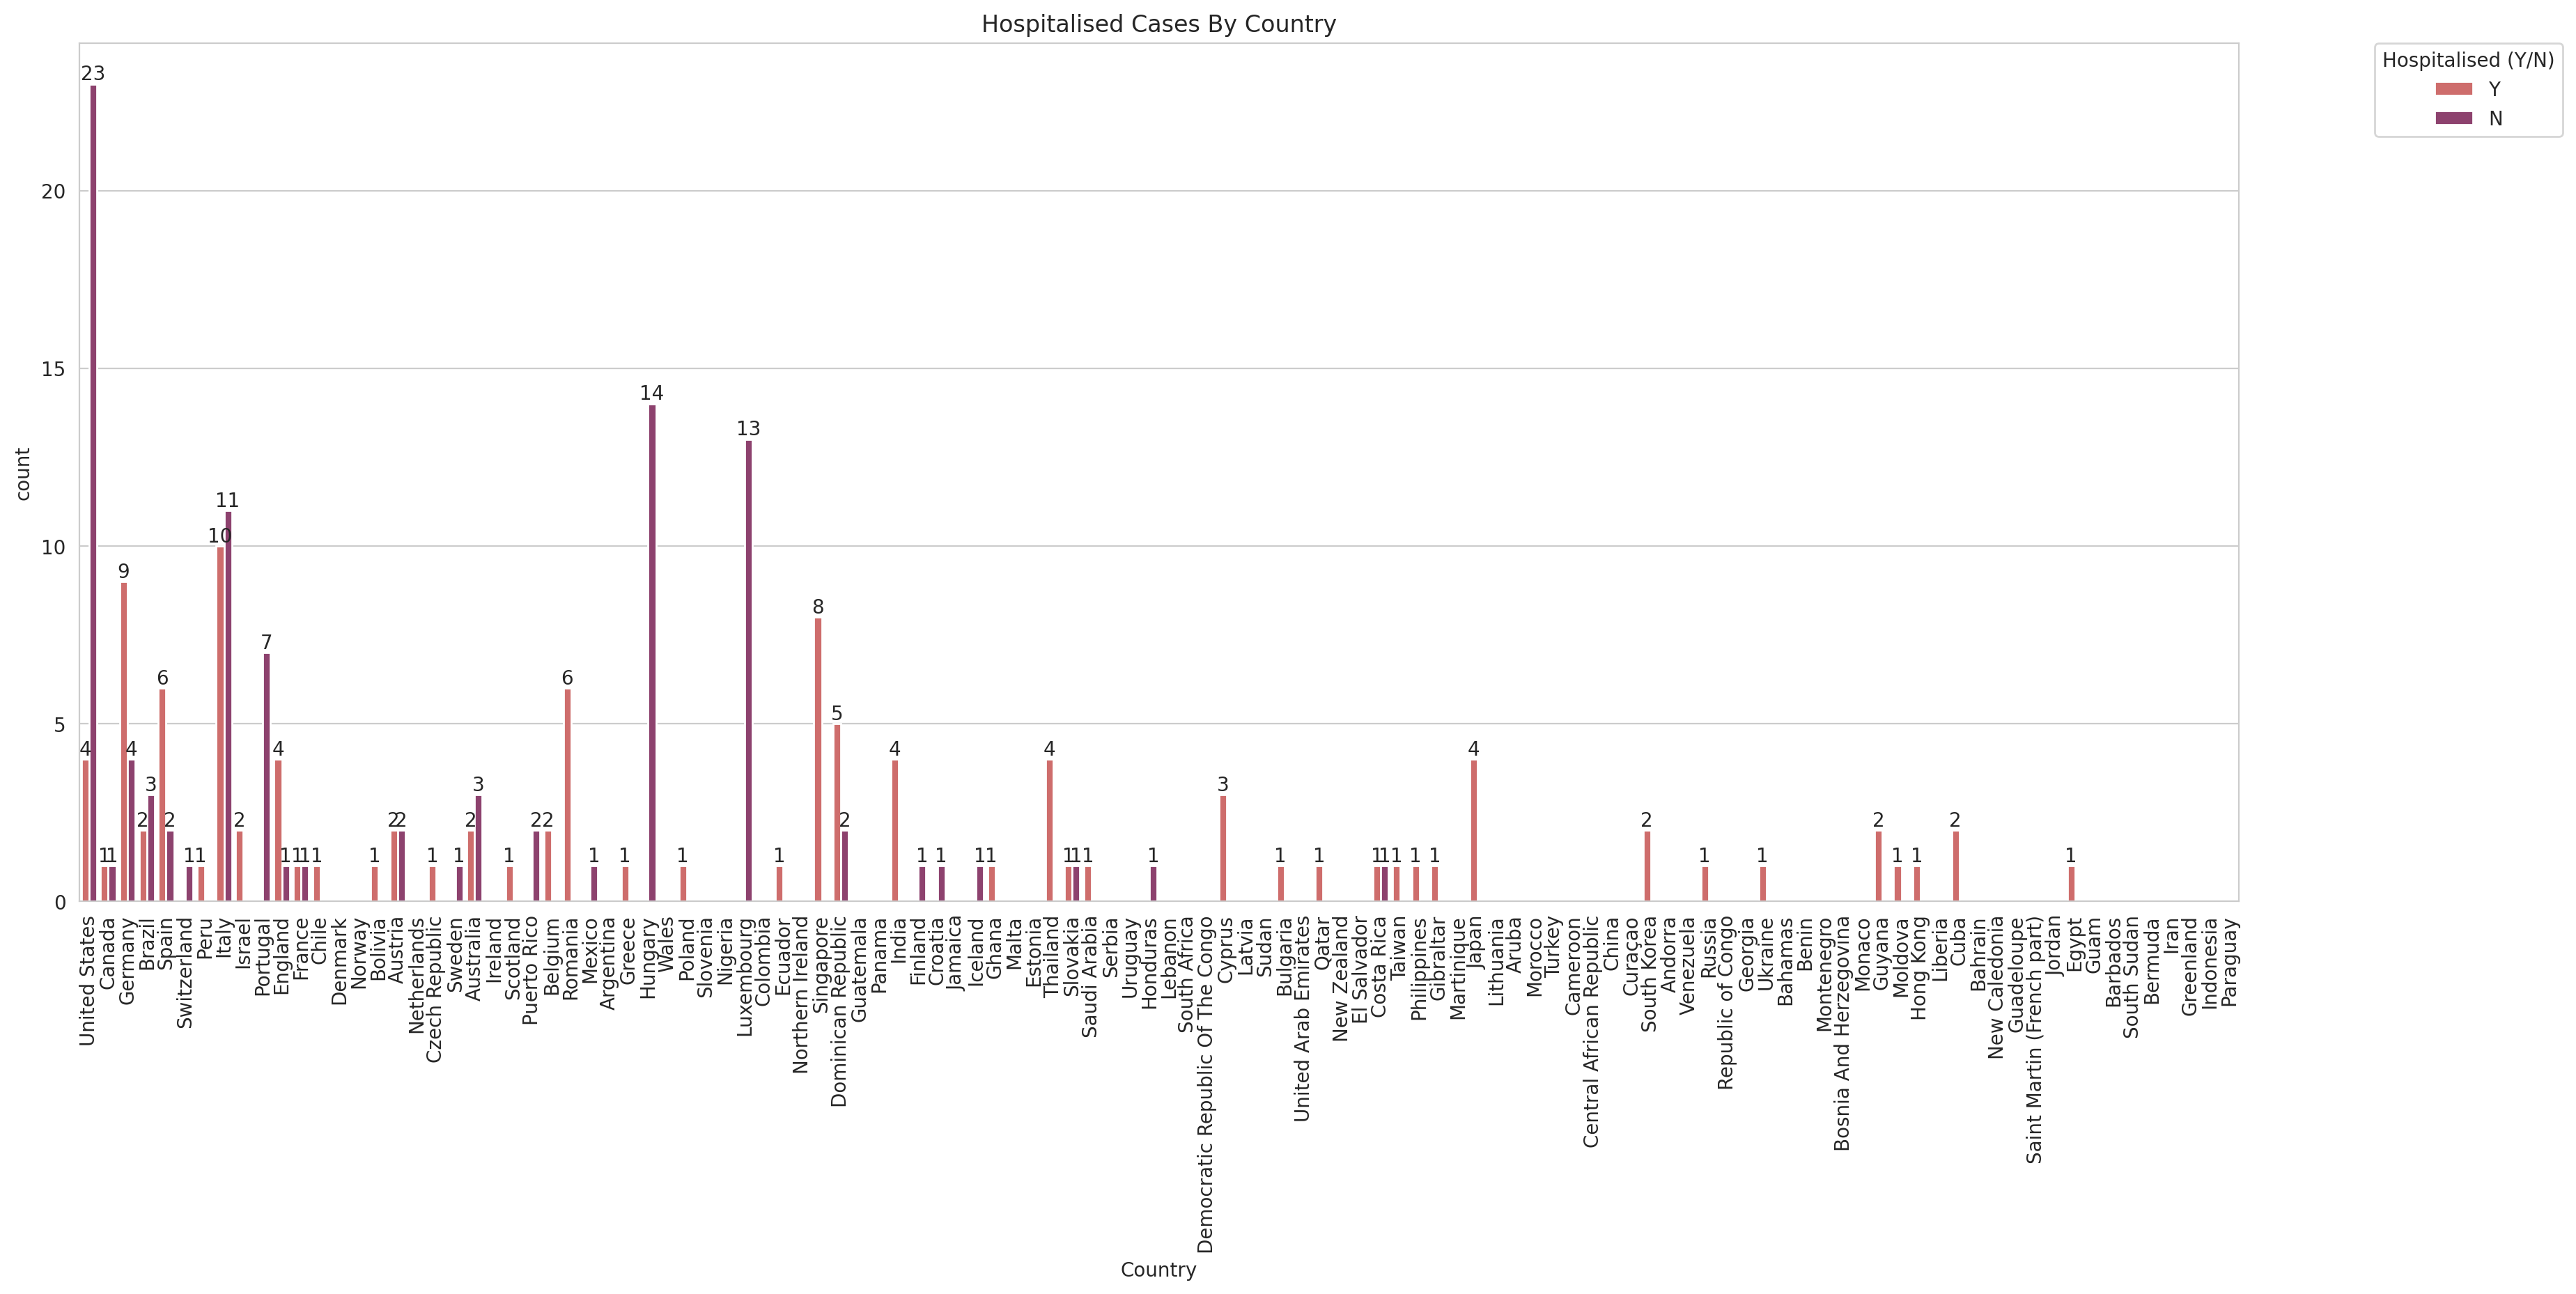

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(20,8))
order = mp_cases_detected.groupby('Country').size().sort_values().index[::-1]
ax = sns.countplot(x="Country", data=mp_cases_detected, hue = "Hospitalised (Y/N/NA)",palette="flare",order=order)
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Hospitalised (Y/N)", bbox_to_anchor=(1.15,1), loc='upper right', borderaxespad=0.)
plt.xticks(rotation = 90)
plt.title("Hospitalised Cases By Country")
plt.show()

## Travel History Gender wise.

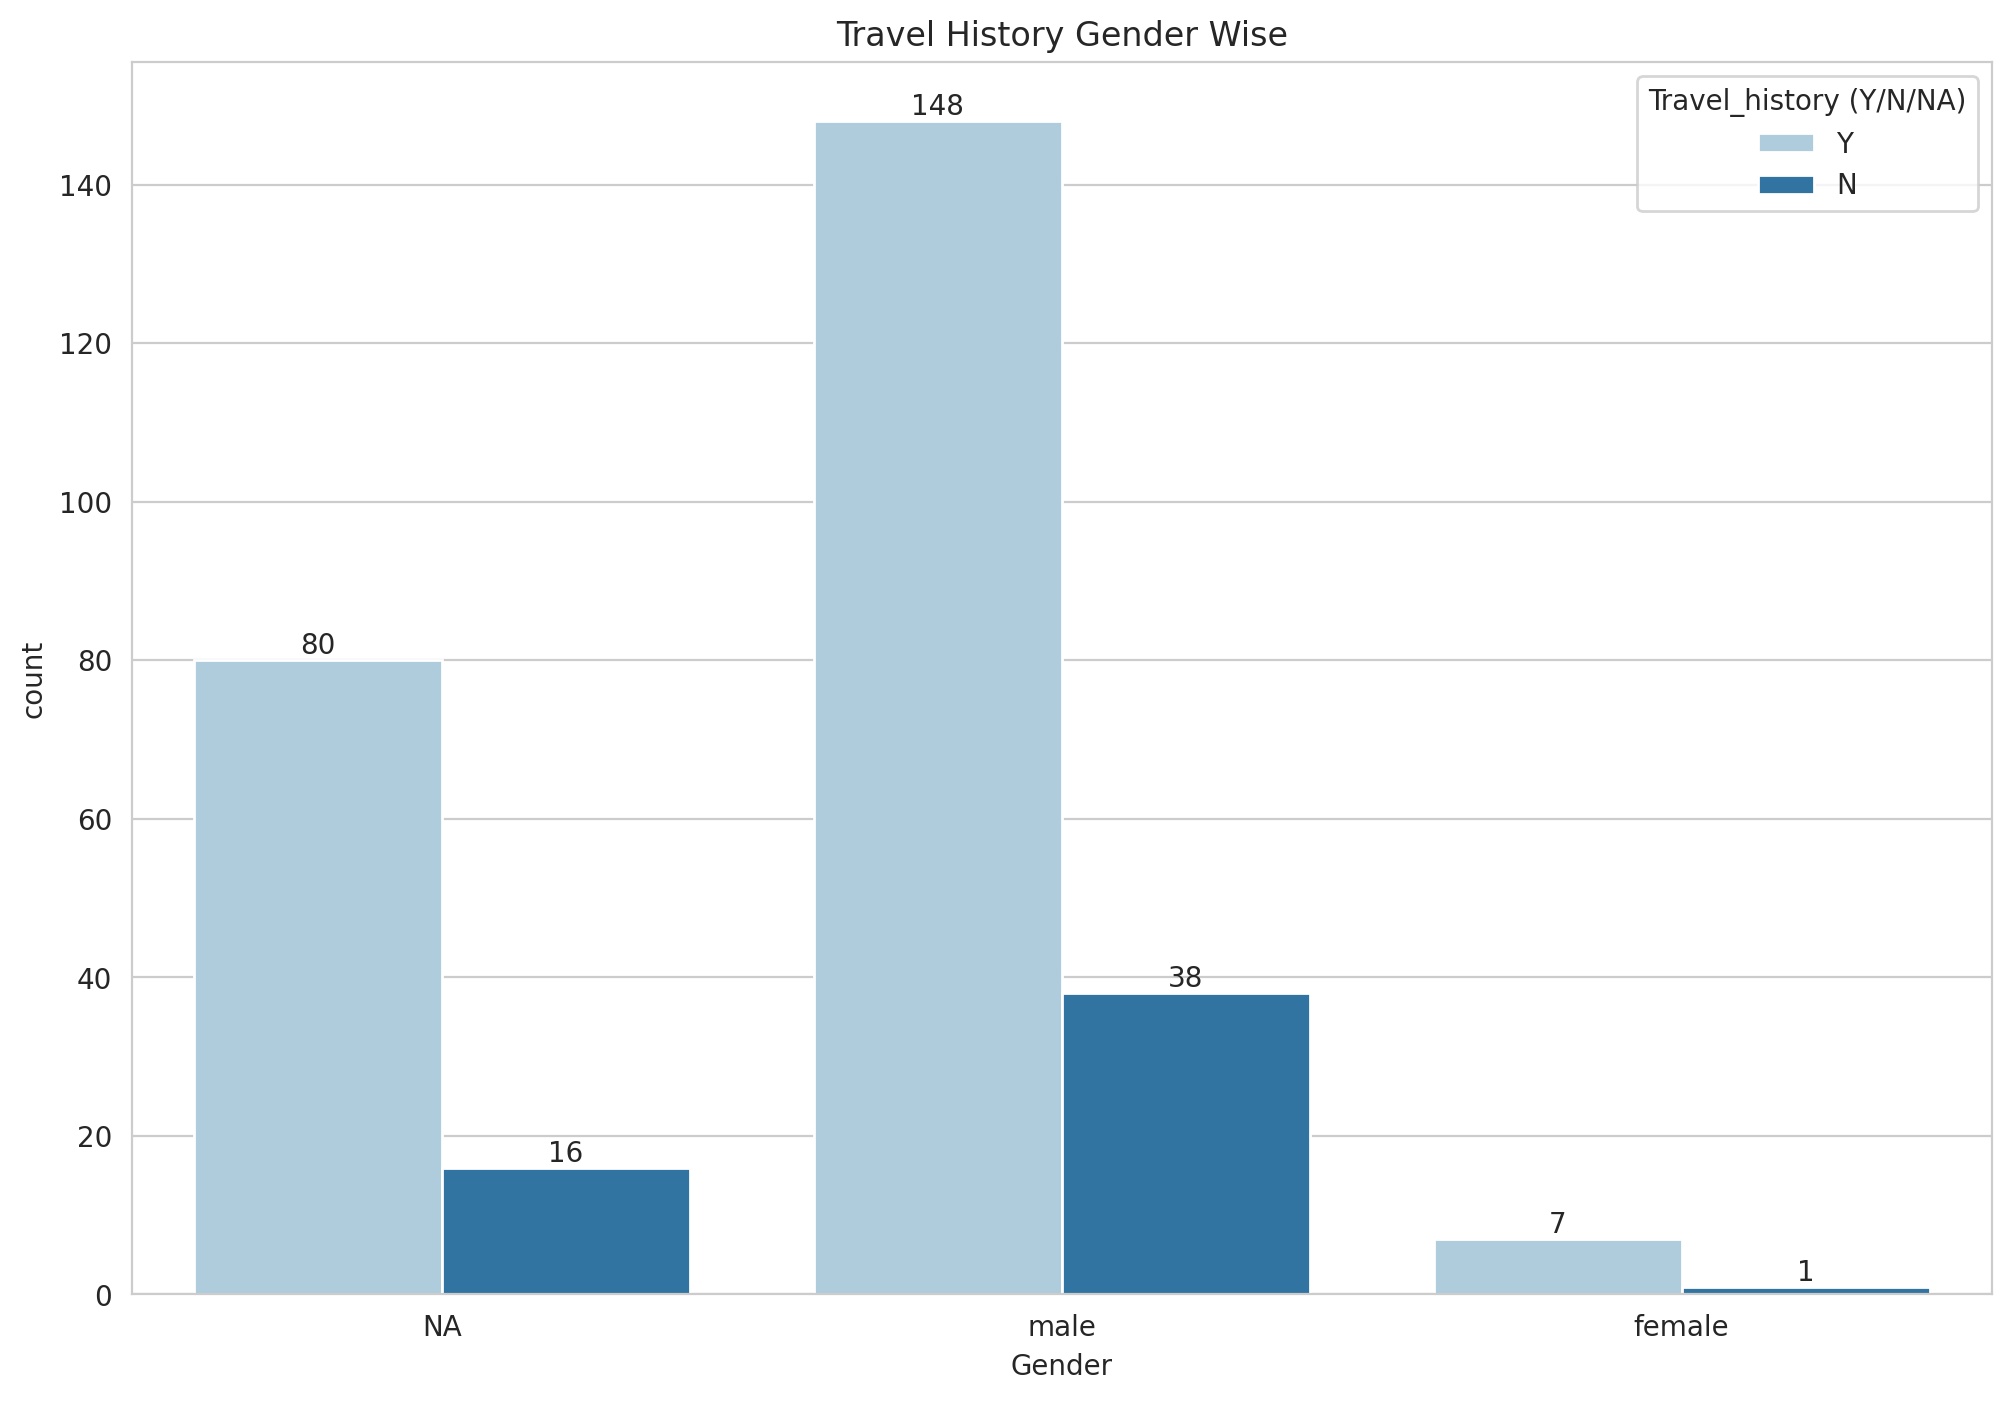

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='Gender',hue='Travel_history (Y/N/NA)',data=mp_cases_detected, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Travel History Gender Wise')
plt.show()

## Virus effect on people of different age groups.

In [ ]:
mp_cases_detected.Age.unique()

array([nan, '0-39', '20-44', '30-34', '25-29', '20-69', '20-64', '40-44',
       '50-59', '40-49', '30-39', '20-59', '30-59', '35-39', '15-74',
       '45-49', '55-59', '15-39', '30-50', '20-49', '50-54', '20-24',
       '15-64', '25-49', '22-55', '40-45', '26-54', '19-59', '30-54',
       '30-49', '20-40', '20-29', '15-69', '40-42', '20-50', '35-40',
       '45-50', '50-55', '31-59', '20-62', '34-46', '20-39', '25-34',
       '35-44', '45-54', '55-64', '28-43', '60-64', '5-9', '36-50',
       '20-60', '65-69', '29-41', '19-24', '25-39', '23-46', '25-53',
       '15-84', '51-65', '20-54', '20-35', '1-69', '15-19', '30-35',
       '23-50', '25-30', '20-46', '20-65', '20-25', '46-50', '0-9',
       '41-45', '0-59', '25-44', '24-29', '15-20', '20-99', '26-30',
       '22-59', '15-59', '0-29', '0-49', '22-43', '31-44', '0-14', '0-69',
       '30-60', '29-43', '25-52', '30-40', '36-42', '18-61', '21-54'],
      dtype=object)

#### Note-
- Converting these age ranges by imputing their mean in place of them.

In [ ]:
mp_cases_detected['Age'] = mp_cases_detected['Age'].fillna('0')
mp_cases_detected['Age'] = mp_cases_detected['Age'].apply(lambda x: np.array(x.split('-'), dtype=int).mean())
mp_cases_detected['Age'] = np.ceil(mp_cases_detected['Age']).astype(int)

In [ ]:
mp_cases_detected.Age.unique()

array([ 0, 20, 32, 27, 45, 42, 55, 35, 40, 37, 47, 57, 52, 22, 39, 43, 30,
       25, 41, 38, 48, 53, 50, 60, 36, 62,  7, 67, 58, 28, 17, 33, 23,  5,
       18, 15])

In [ ]:
mp_cases_detected.Age.value_counts().sort_values(ascending=False)

Age
0     1564
45     124
40      92
32      84
42      65
37      54
27      52
35      50
39      25
22      22
47      14
30      12
60      11
25      11
52       8
43       7
55       5
28       5
38       4
23       4
33       4
57       4
36       3
41       3
50       3
62       2
7        2
67       2
58       2
17       2
48       2
20       2
5        2
18       2
53       1
15       1
Name: count, dtype: int64

In [ ]:
ages_selected = mp_cases_detected[mp_cases_detected['Age']>0]
fig = px.histogram(ages_selected,x='Age',nbins=25,color_discrete_sequence = px.colors.qualitative.Set3, title="Virus affected different age groups")
fig.show()

#### Observations:
- We can observe that the virus is mainly targeting the people around 40s.
- Children of less age are being affected too.

# Time Series Analysis of Daily Reported Cases.


In [ ]:
mp_cases_confirmed.head()

Country  2022-01-31  2022-02-17  2022-02-28  2022-03-04  \
0                   Nigeria           3           0           1           0   
1                  Cameroon           0           3           0           0   
2  Central African Republic           0           0           0           2   
3         Republic of Congo           0           0           0           0   
4                   England           0           0           0           0   

   2022-03-31  2022-04-10  2022-04-12  2022-04-30  2022-05-06  ...  \
0           6           0           0           5           0  ...   
1           0           0           0           0           0  ...   
2           0           4           0           0           0  ...   
3           0           0           2           0           0  ...   
4           0           0           0           0           1  ...   

   2022-09-13  2022-09-14  2022-09-15  2022-09-16  2022-09-17  2022-09-18  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   2022-09-19  2022-09-20  2022-09-21  2022-09-22  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0          29           0           0  

[5 rows x 142 columns]

In [ ]:
mp_cases_confirmed.set_index('Country', inplace=True)
mp_cases_confirmed.head()

2022-01-31  2022-02-17  2022-02-28  2022-03-04  \
Country                                                                    
Nigeria                            3           0           1           0   
Cameroon                           0           3           0           0   
Central African Republic           0           0           0           2   
Republic of Congo                  0           0           0           0   
England                            0           0           0           0   

                          2022-03-31  2022-04-10  2022-04-12  2022-04-30  \
Country                                                                    
Nigeria                            6           0           0           5   
Cameroon                           0           0           0           0   
Central African Republic           0           4           0           0   
Republic of Congo                  0           0           2           0   
England                            0           0           0           0   

                          2022-05-06  2022-05-08  ...  2022-09-13  2022-09-14  \
Country                                           ...                           
Nigeria                            0           0  ...           0           0   
Cameroon                           0           0  ...           0           0   
Central African Republic           0           0  ...           0           0   
Republic of Congo                  0           0  ...           0           0   
England                            1           0  ...           0           0   

                          2022-09-15  2022-09-16  2022-09-17  2022-09-18  \
Country                                                                    
Nigeria                            0           0           0           0   
Cameroon                           0           0           0           0   
Central African Republic           0           0           0           0   
Republic of Congo                  0           0           0           0   
England                            0           0           0           0   

                          2022-09-19  2022-09-20  2022-09-21  2022-09-22  
Country                                                                   
Nigeria                            0           0           0           0  
Cameroon                           0           0           0           0  
Central African Republic           0           0           0           0  
Republic of Congo                  0           0           0           0  
England                            0          29           0           0  

[5 rows x 141 columns]

In [ ]:
daily_country_cases = mp_cases_confirmed.T
daily_country_cases.head()

Country     Nigeria  Cameroon  Central African Republic  Republic of Congo  \
2022-01-31        3         0                         0                  0   
2022-02-17        0         3                         0                  0   
2022-02-28        1         0                         0                  0   
2022-03-04        0         0                         2                  0   
2022-03-31        6         0                         0                  0   

Country     England  Democratic Republic Of The Congo  Portugal  Spain  \
2022-01-31        0                                 0         0      0   
2022-02-17        0                                 0         0      0   
2022-02-28        0                                 0         0      0   
2022-03-04        0                                 0         0      0   
2022-03-31        0                                 0         0      0   

Country     United States  Belgium  ...  Paraguay  South Sudan  El Salvador  \
2022-01-31              0        0  ...         0            0            0   
2022-02-17              0        0  ...         0            0            0   
2022-02-28              0        0  ...         0            0            0   
2022-03-04              0        0  ...         0            0            0   
2022-03-31              0        0  ...         0            0            0   

Country     Hong Kong  Egypt  Jordan  Guam  Ukraine  Bahrain  China  
2022-01-31          0      0       0     0        0        0      0  
2022-02-17          0      0       0     0        0        0      0  
2022-02-28          0      0       0     0        0        0      0  
2022-03-04          0      0       0     0        0        0      0  
2022-03-31          0      0       0     0        0        0      0  

[5 rows x 112 columns]

In [ ]:
daily_country_cases['Total_cases'] = daily_country_cases.sum(axis=1)
daily_country_cases['Total_cases']

2022-01-31       3
2022-02-17       3
2022-02-28       1
2022-03-04       2
2022-03-31       6
              ... 
2022-09-18       4
2022-09-19    1355
2022-09-20     660
2022-09-21     486
2022-09-22     311
Name: Total_cases, Length: 141, dtype: int64

In [ ]:
# Setting index format as datetime in order to allow manipulation of date/time for time-series analysis
daily_country_cases.index = pd.to_datetime(daily_country_cases.index)

## Daily Reported Cases Over Time


In [ ]:
fig = px.line(daily_country_cases, y='Total_cases',labels={'Total_cases':'Total Cases','index':'Date'},
              title='Monkey Pox Cases Reported Daily Over Time',color_discrete_sequence=['#6F2DBD'], markers=True)
fig.update_layout(hovermode="x")
fig.show()

## Decomposing using statsmodel:

#### <span style="color:green;"><blockquote>The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.</blockquote></span>

- We will now be able to see the trend, seasonal, and residual components of our data.

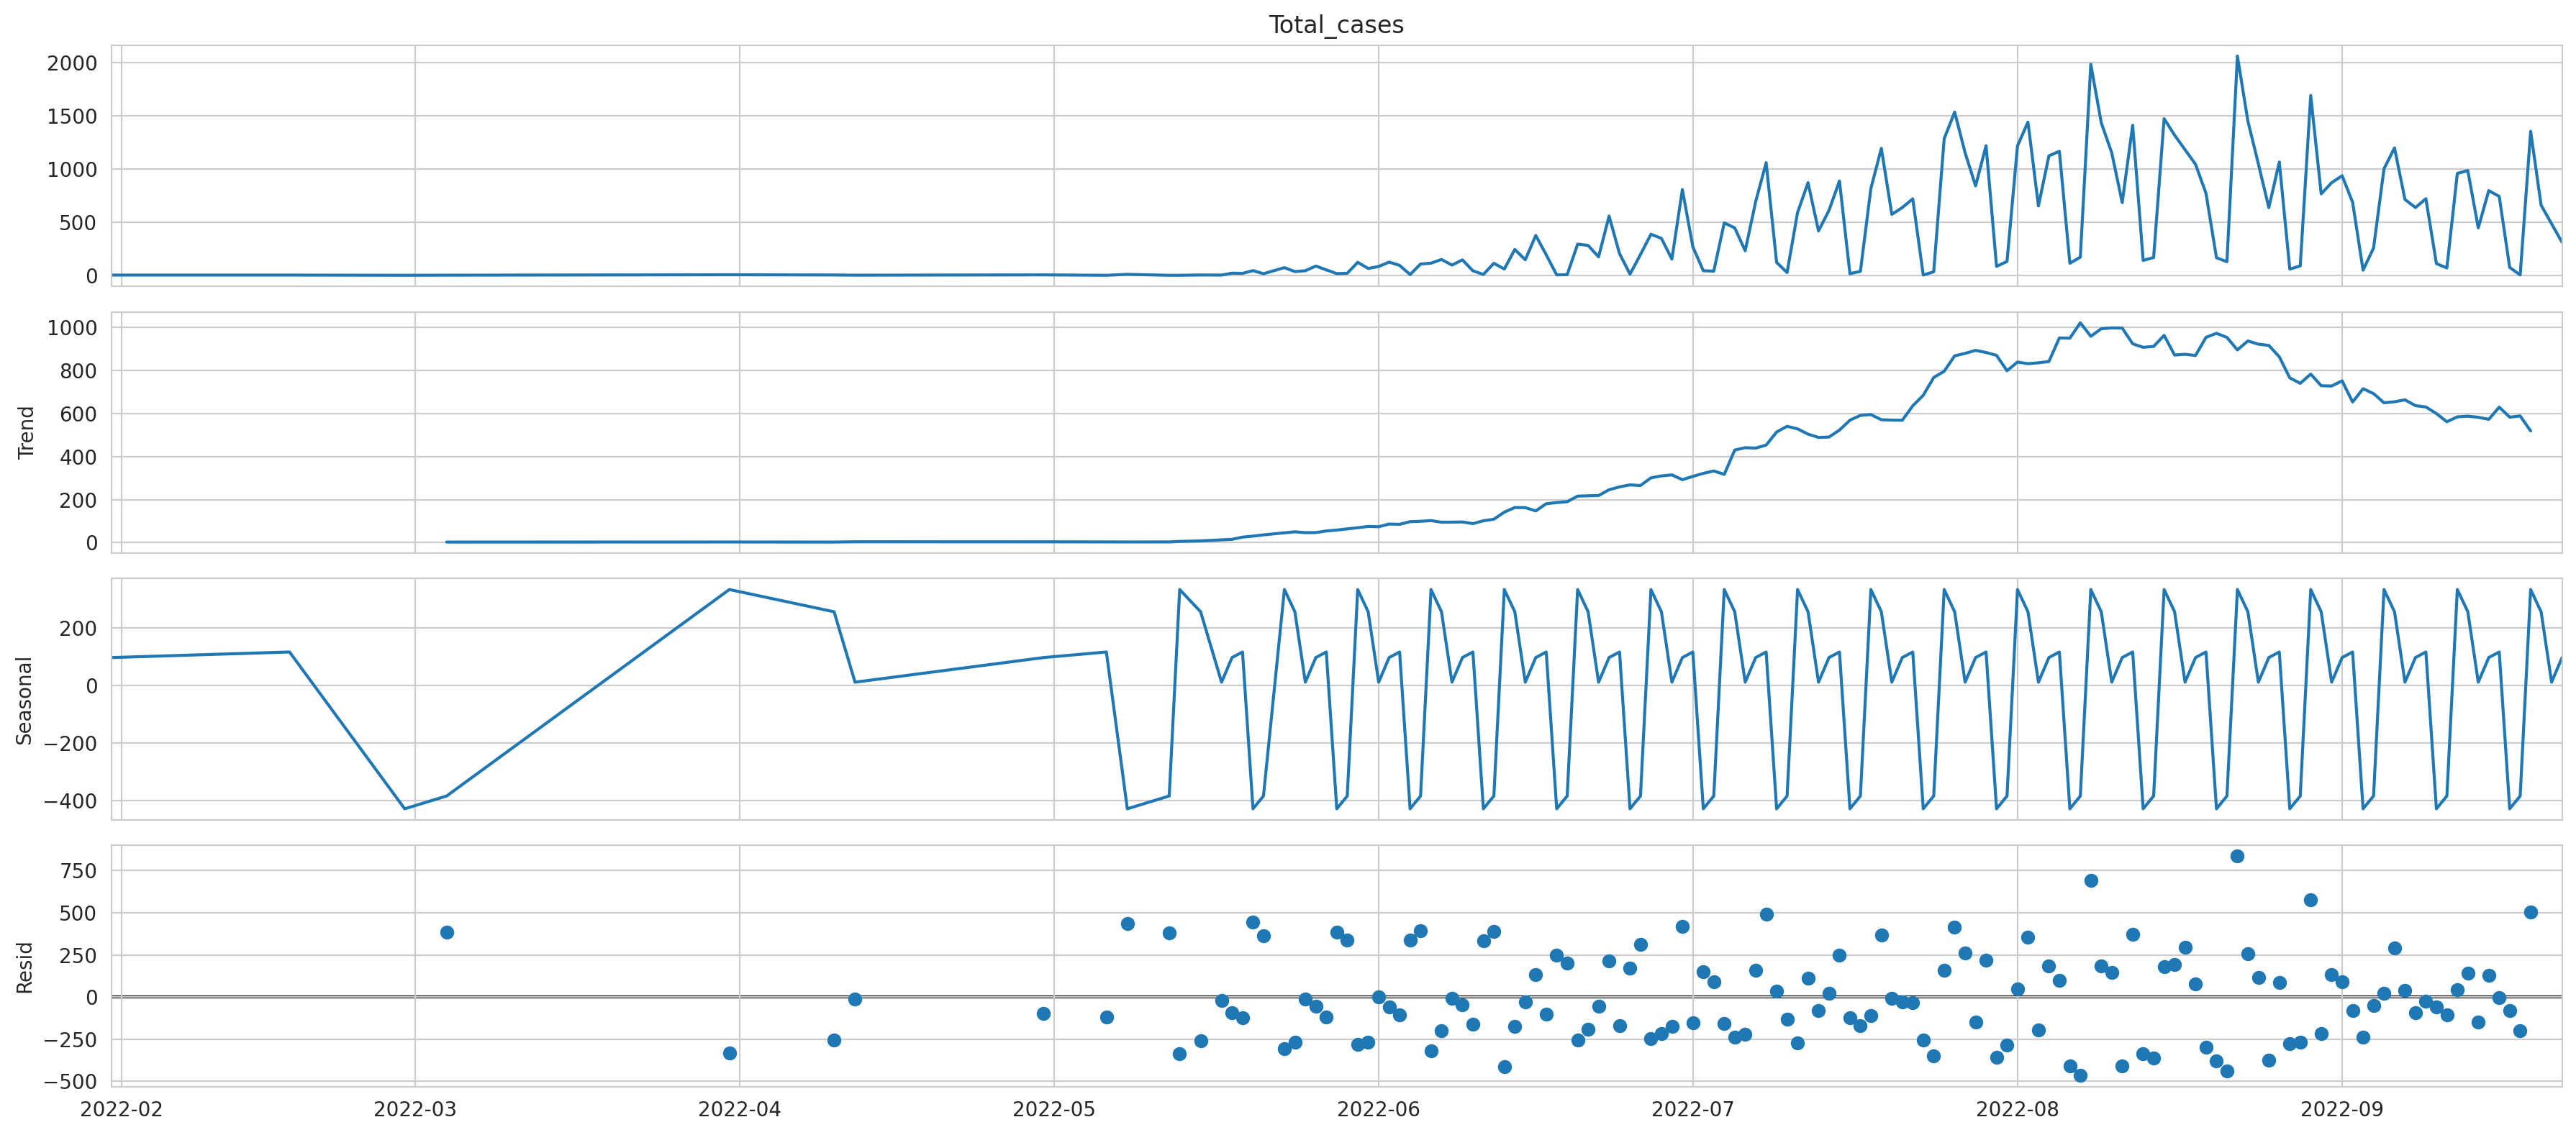

In [ ]:
rcParams['figure.figsize'] = (18, 8)

decomposition = sm.tsa.seasonal_decompose(daily_country_cases['Total_cases'], model = 'additive',period=7)
fig = decomposition.plot()
plt.show()

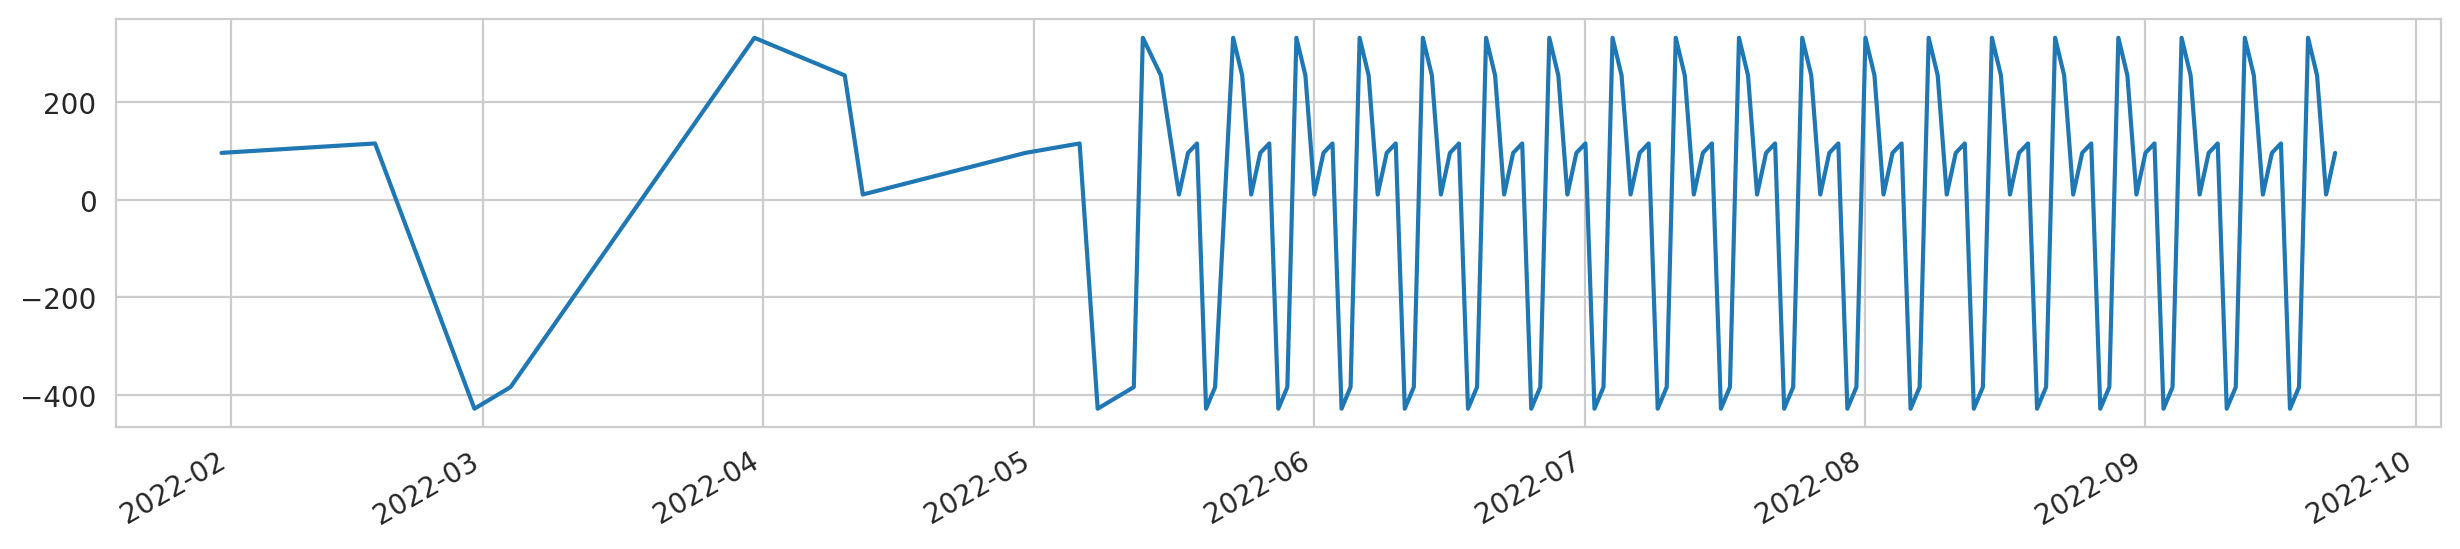

In [ ]:
plt.figure(figsize=(15,3))
decomposition.seasonal.plot()
plt.show()

#### Observations:
- We can conclude that the time series is non-stationary since it has seasonality.

- We need to perform a statistical test on the time series to prove this non-stationarity.

- For that, we will use the Augmented Dickey-Fuller test.

## Implementing Augmented Dickey-Fuller Test.


#### <span style="color:green;"><blockquote>The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. We set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.</blockquote></span>

- **Null Hypothesis**: The data is not stationary.

- **Alternative Hypothesis**: The data is stationary.

In our case, for the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

- p-value <= significance level (0.05)
- If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [ ]:
passing_data=adfuller(daily_country_cases['Total_cases'])

def adf_test(cases):
    result=adfuller(cases)
    labels = ['Test parameters', 'p-value','#Lags Used','Dataset observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Dataset is stationary")
    else:
        print("Dataset is non-stationary ")

In [ ]:
adf_test(daily_country_cases['Total_cases'])

Test parameters : -1.4620736671126264
p-value : 0.5521826387304754
#Lags Used : 13
Dataset observations : 127
Dataset is non-stationary 


#### Observations:
- We have different output values that show the nature of our dataset. We are only interested in the p-value result.
- We will have to make the time series stationary using the differencing approach.

## Implementing Differencing

<blockquote>This approach finds the difference between the current day cases and the previous day cases in the time series.<br>
We will difference only once, therefore our d=1.</blockquote>

In [ ]:
#daily_country_cases['Differencing']= daily_country_cases['Total_cases'].diff(periods=2)

In [ ]:
daily_country_cases['Differencing']=daily_country_cases['Total_cases']-daily_country_cases['Total_cases'].shift(1)

adf_test(daily_country_cases['Differencing'].dropna())

Test parameters : -2.5599664574826084
p-value : 0.10155684318767921
#Lags Used : 14
Dataset observations : 125
Dataset is non-stationary 


#### Observations:
- From the test results it shows, the dataset has become stationary.
- We will plot this new time series to see whether we have removed the seasonal components.

In [ ]:
# Second-order differencing
daily_country_cases['Differencing_2'] = daily_country_cases['Differencing'] - daily_country_cases['Differencing'].shift(1)

adf_test(daily_country_cases['Differencing_2'].dropna())

Test parameters : -7.476342898274846
p-value : 4.902328095731692e-11
#Lags Used : 13
Dataset observations : 125
Dataset is stationary


In [ ]:
fig = px.line(daily_country_cases, y='Differencing_2',labels={'Total_cases':'Total Cases','index':'Date'},
              title='Monkey Pox Cases Reported Daily Over Time',color_discrete_sequence=['#6F2DBD'], markers=True)
fig.update_layout(hovermode="x")
fig.show()

#### Note-
- We have removed the seasonal components. Now, we can start applying the ARIMA model to the dataset.

## Implementing the ARIMA model

#### <span style="color:green;"><blockquote>We initialize the ARIMA model as ARIMA (p,d,q). So we need to get the values of these parameters. Here d=1, because we applied differencing once.</blockquote></span>

#### Getting the best ‘p’ and ‘q’ values:
- We get the best value of q using an Autocorrelation Function (ACF) plot.
- We get the best value of p using a Partial Autocorrelation Function (PACF) plot.

*Let's plot ACF and PACF !!*

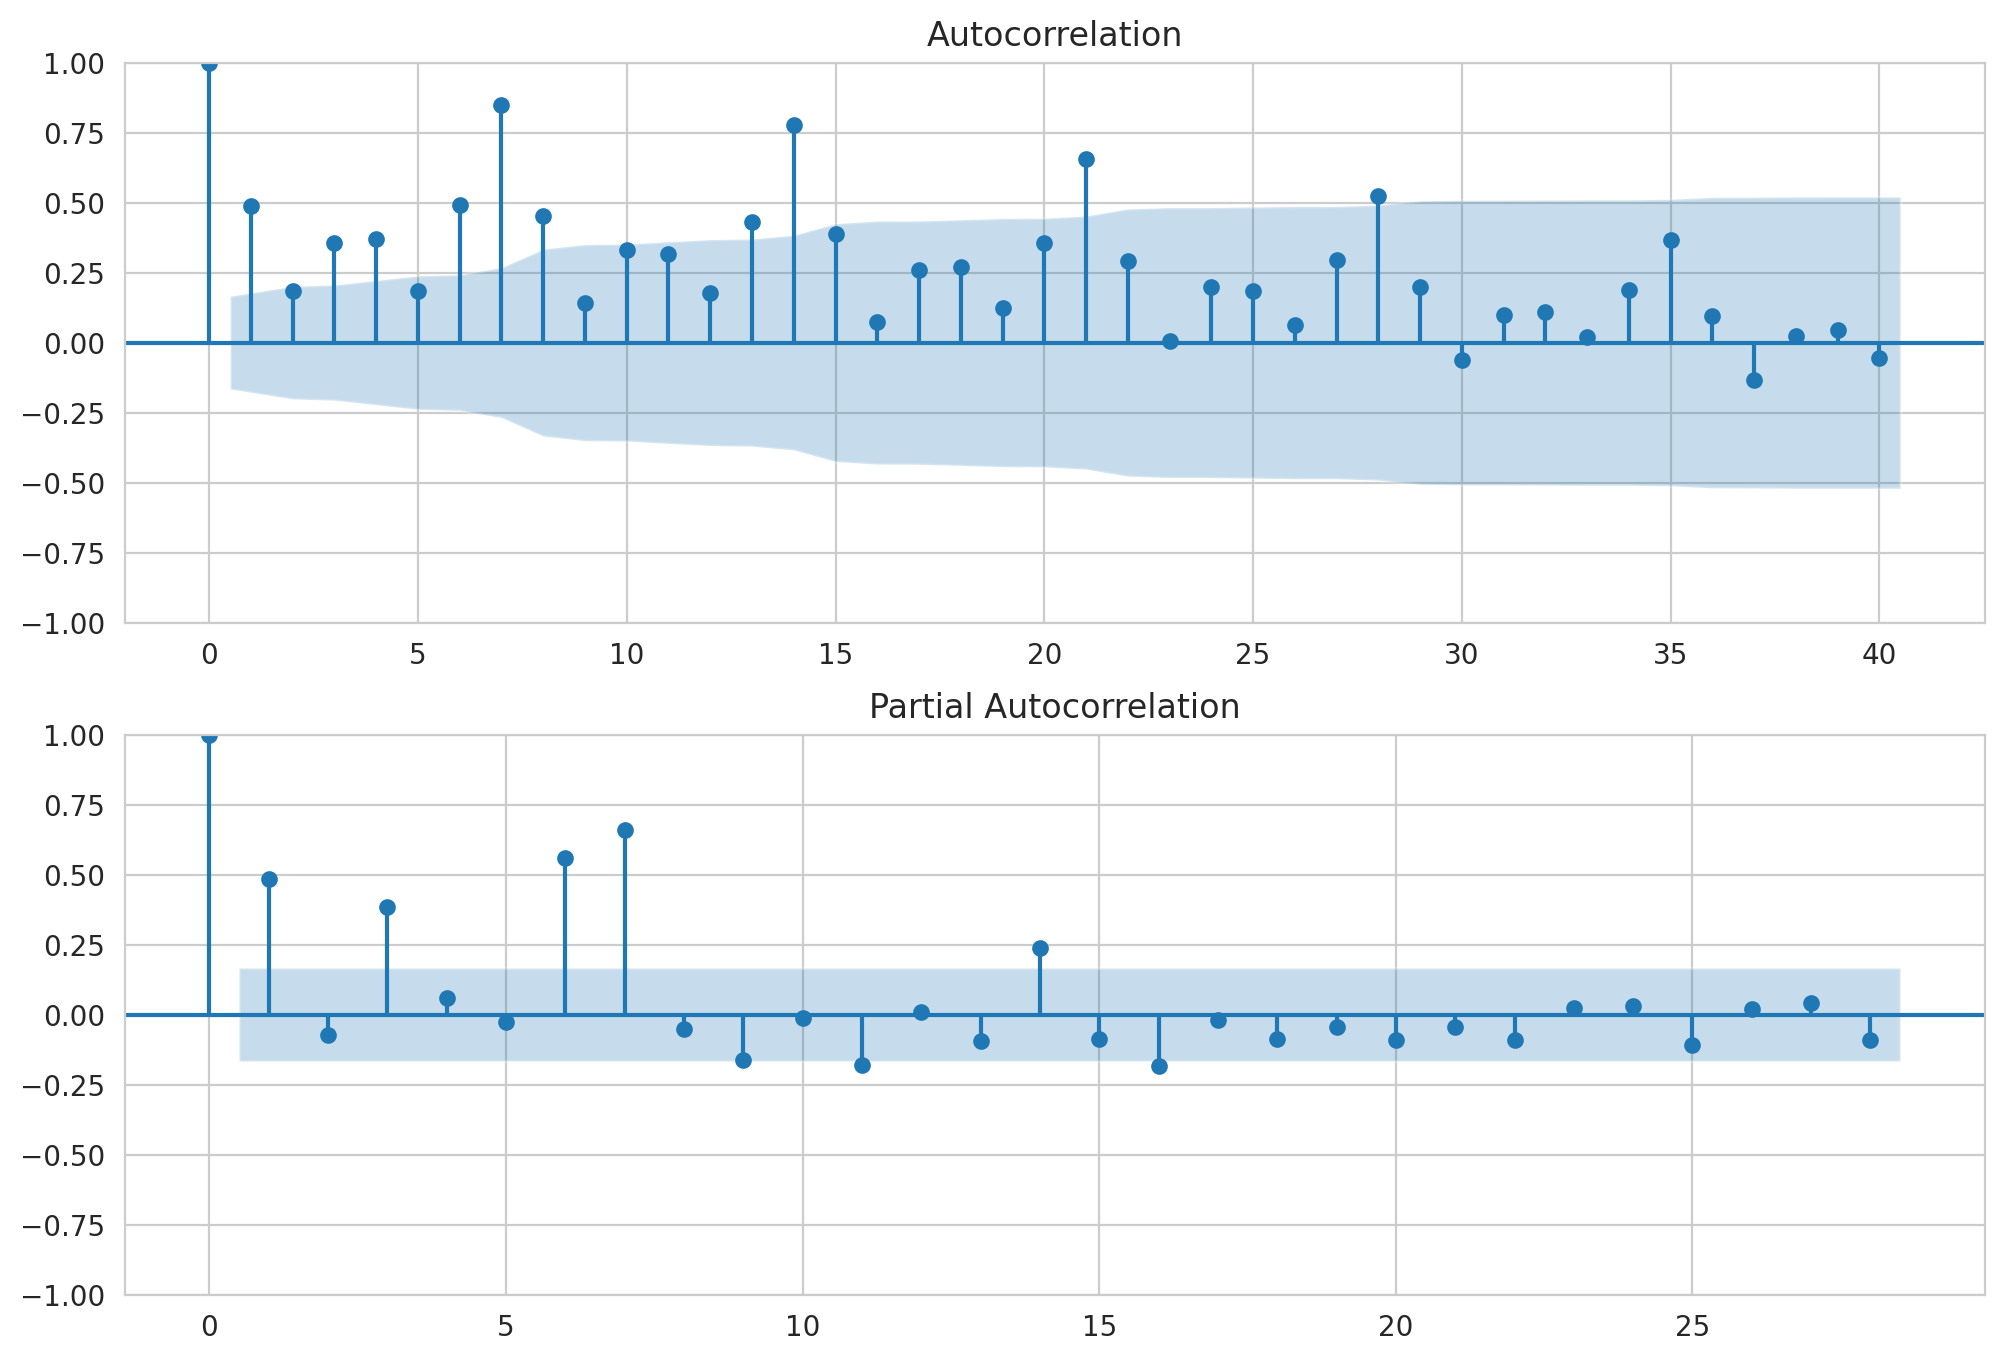

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(daily_country_cases['Total_cases'].iloc[1:],lags=40,ax=ax1)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_country_cases['Total_cases'].iloc[2:],lags=28,ax=ax1)

In [ ]:
daily_country_cases.index = pd.DatetimeIndex(daily_country_cases.index).to_period('D')

### Splitting the dataset into train and test.

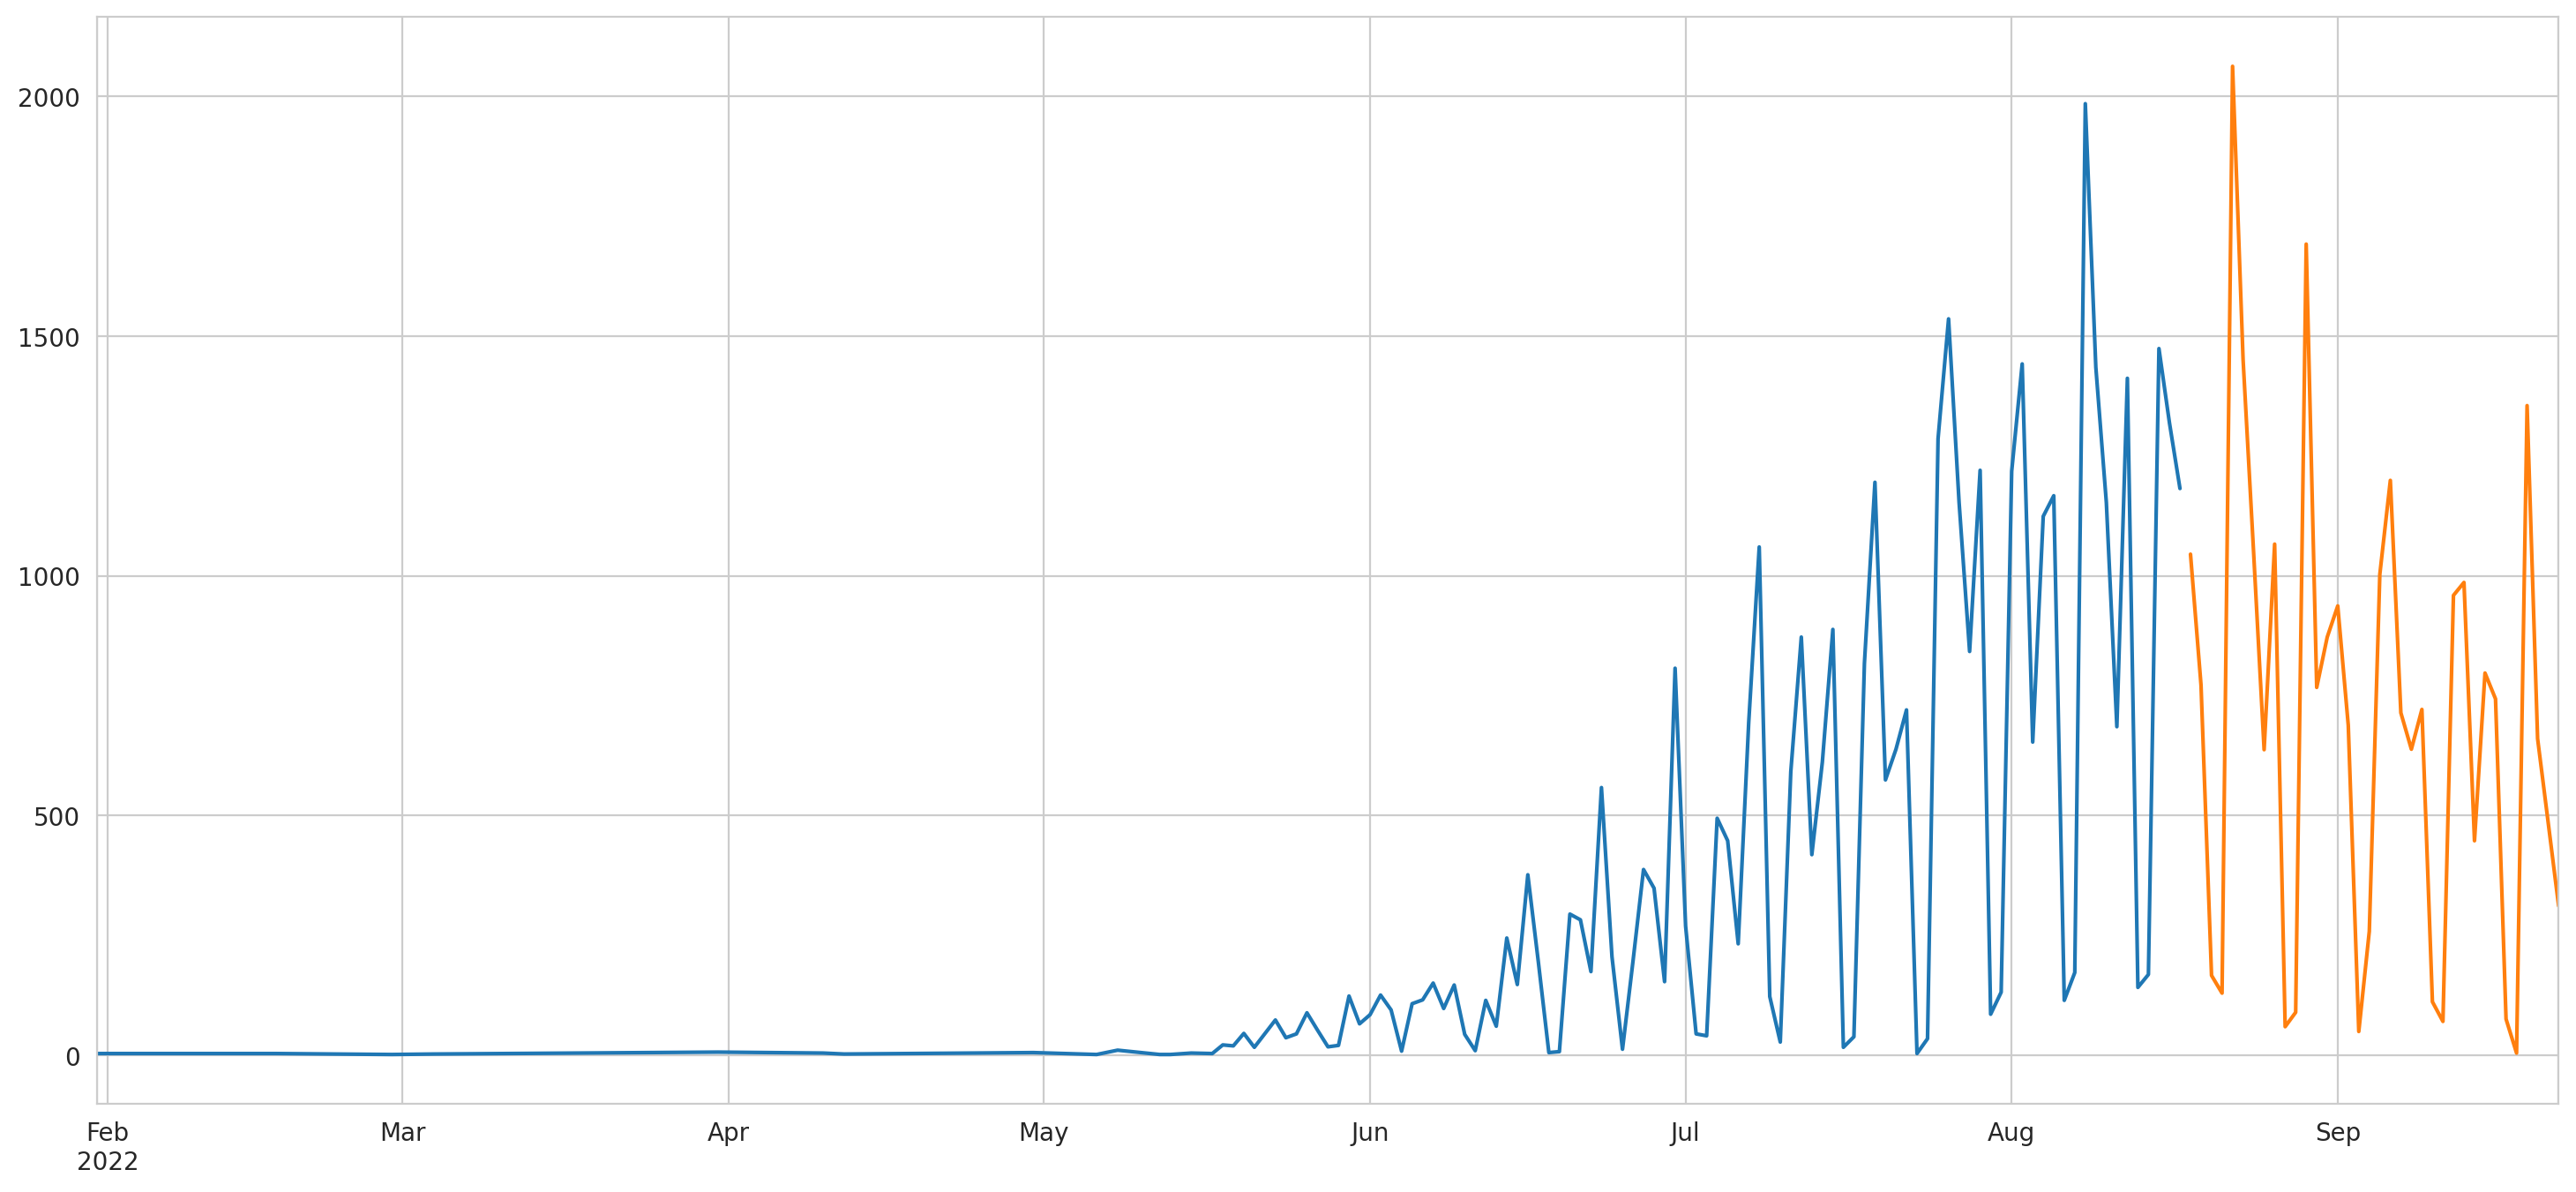

In [ ]:
#divide into train and validation set
train = daily_country_cases[:int(0.75*(len(daily_country_cases)))]
test = daily_country_cases[int(0.75*(len(daily_country_cases))):]

#plotting the data
train['Total_cases'].plot()
test['Total_cases'].plot()
plt.show()

## Training the ARIMA Model

In [ ]:
model=sm.tsa.arima.ARIMA(daily_country_cases['Total_cases'],order=(12,2,9))
arima_model = model.fit()

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total_cases   No. Observations:                  141
Model:                ARIMA(12, 2, 9)   Log Likelihood                -942.053
Date:                Wed, 03 Jul 2024   AIC                           1928.106
Time:                        09:38:30   BIC                           1992.664
Sample:                    01-31-2022   HQIC                          1954.341
                         - 09-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1625      1.095     -1.061      0.288      -3.309       0.984
ar.L2         -0.7917      1.099     -0.720      0.471      -2.946       1.363
ar.L3         -1.2438      1.053     -1.181      0.238      -3.308       0.820
ar.L4         -1.0085      1.184     -0.852      0.394      -3.330       1.313
ar.L5         -0.9350      1.080     -0.866      0.387      -3.052       1.182
ar.L6         -1.1577      1.161     -0.998      0.318      -3.432       1.117
ar.L7         -0.2696      1.095     -0.246      0.805      -2.416       1.876
ar.L8         -0.1113      0.481     -0.232      0.817      -1.053       0.831
ar.L9         -0.4184      0.410     -1.022      0.307      -1.221       0.384
ar.L10        -0.0411      0.541     -0.076      0.940      -1.102       1.020
ar.L11        -0.1985      0.437     -0.454      0.650      -1.055       0.658
ar.L12        -0.2708      0.354     -0.764      0.445      -0.965       0.424
ma.L1         -0.7802      1.104     -0.707      0.480      -2.944       1.383
ma.L2         -0.5865      1.240     -0.473      0.636      -3.018       1.844
ma.L3          0.7575      0.603      1.255      0.209      -0.425       1.940
ma.L4         -0.4612      0.893     -0.516      0.606      -2.212       1.290
ma.L5         -0.0653      0.543     -0.120      0.904      -1.130       1.000
ma.L6          0.4693      0.556      0.845      0.398      -0.620       1.558
ma.L7         -0.4306      0.426     -1.011      0.312      -1.266       0.404
ma.L8          0.0539      0.540      0.100      0.920      -1.004       1.112
ma.L9          0.2314      0.492      0.471      0.638      -0.732       1.195
sigma2      5.082e+04   7147.472      7.111      0.000    3.68e+04    6.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 8.34
Prob(Q):                              0.71   Prob(JB):                         0.02
Heteroskedasticity (H):              21.07   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Model Diagnostics
We can interpret the model as a good fit based on the following conditions.

- **Standardized residual**

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

- **Histogram plus KDE estimate**

The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

- **Normal Q-Q**

Most of the data points should lie on the straight line

- **Correlogram (ACF plot)**

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

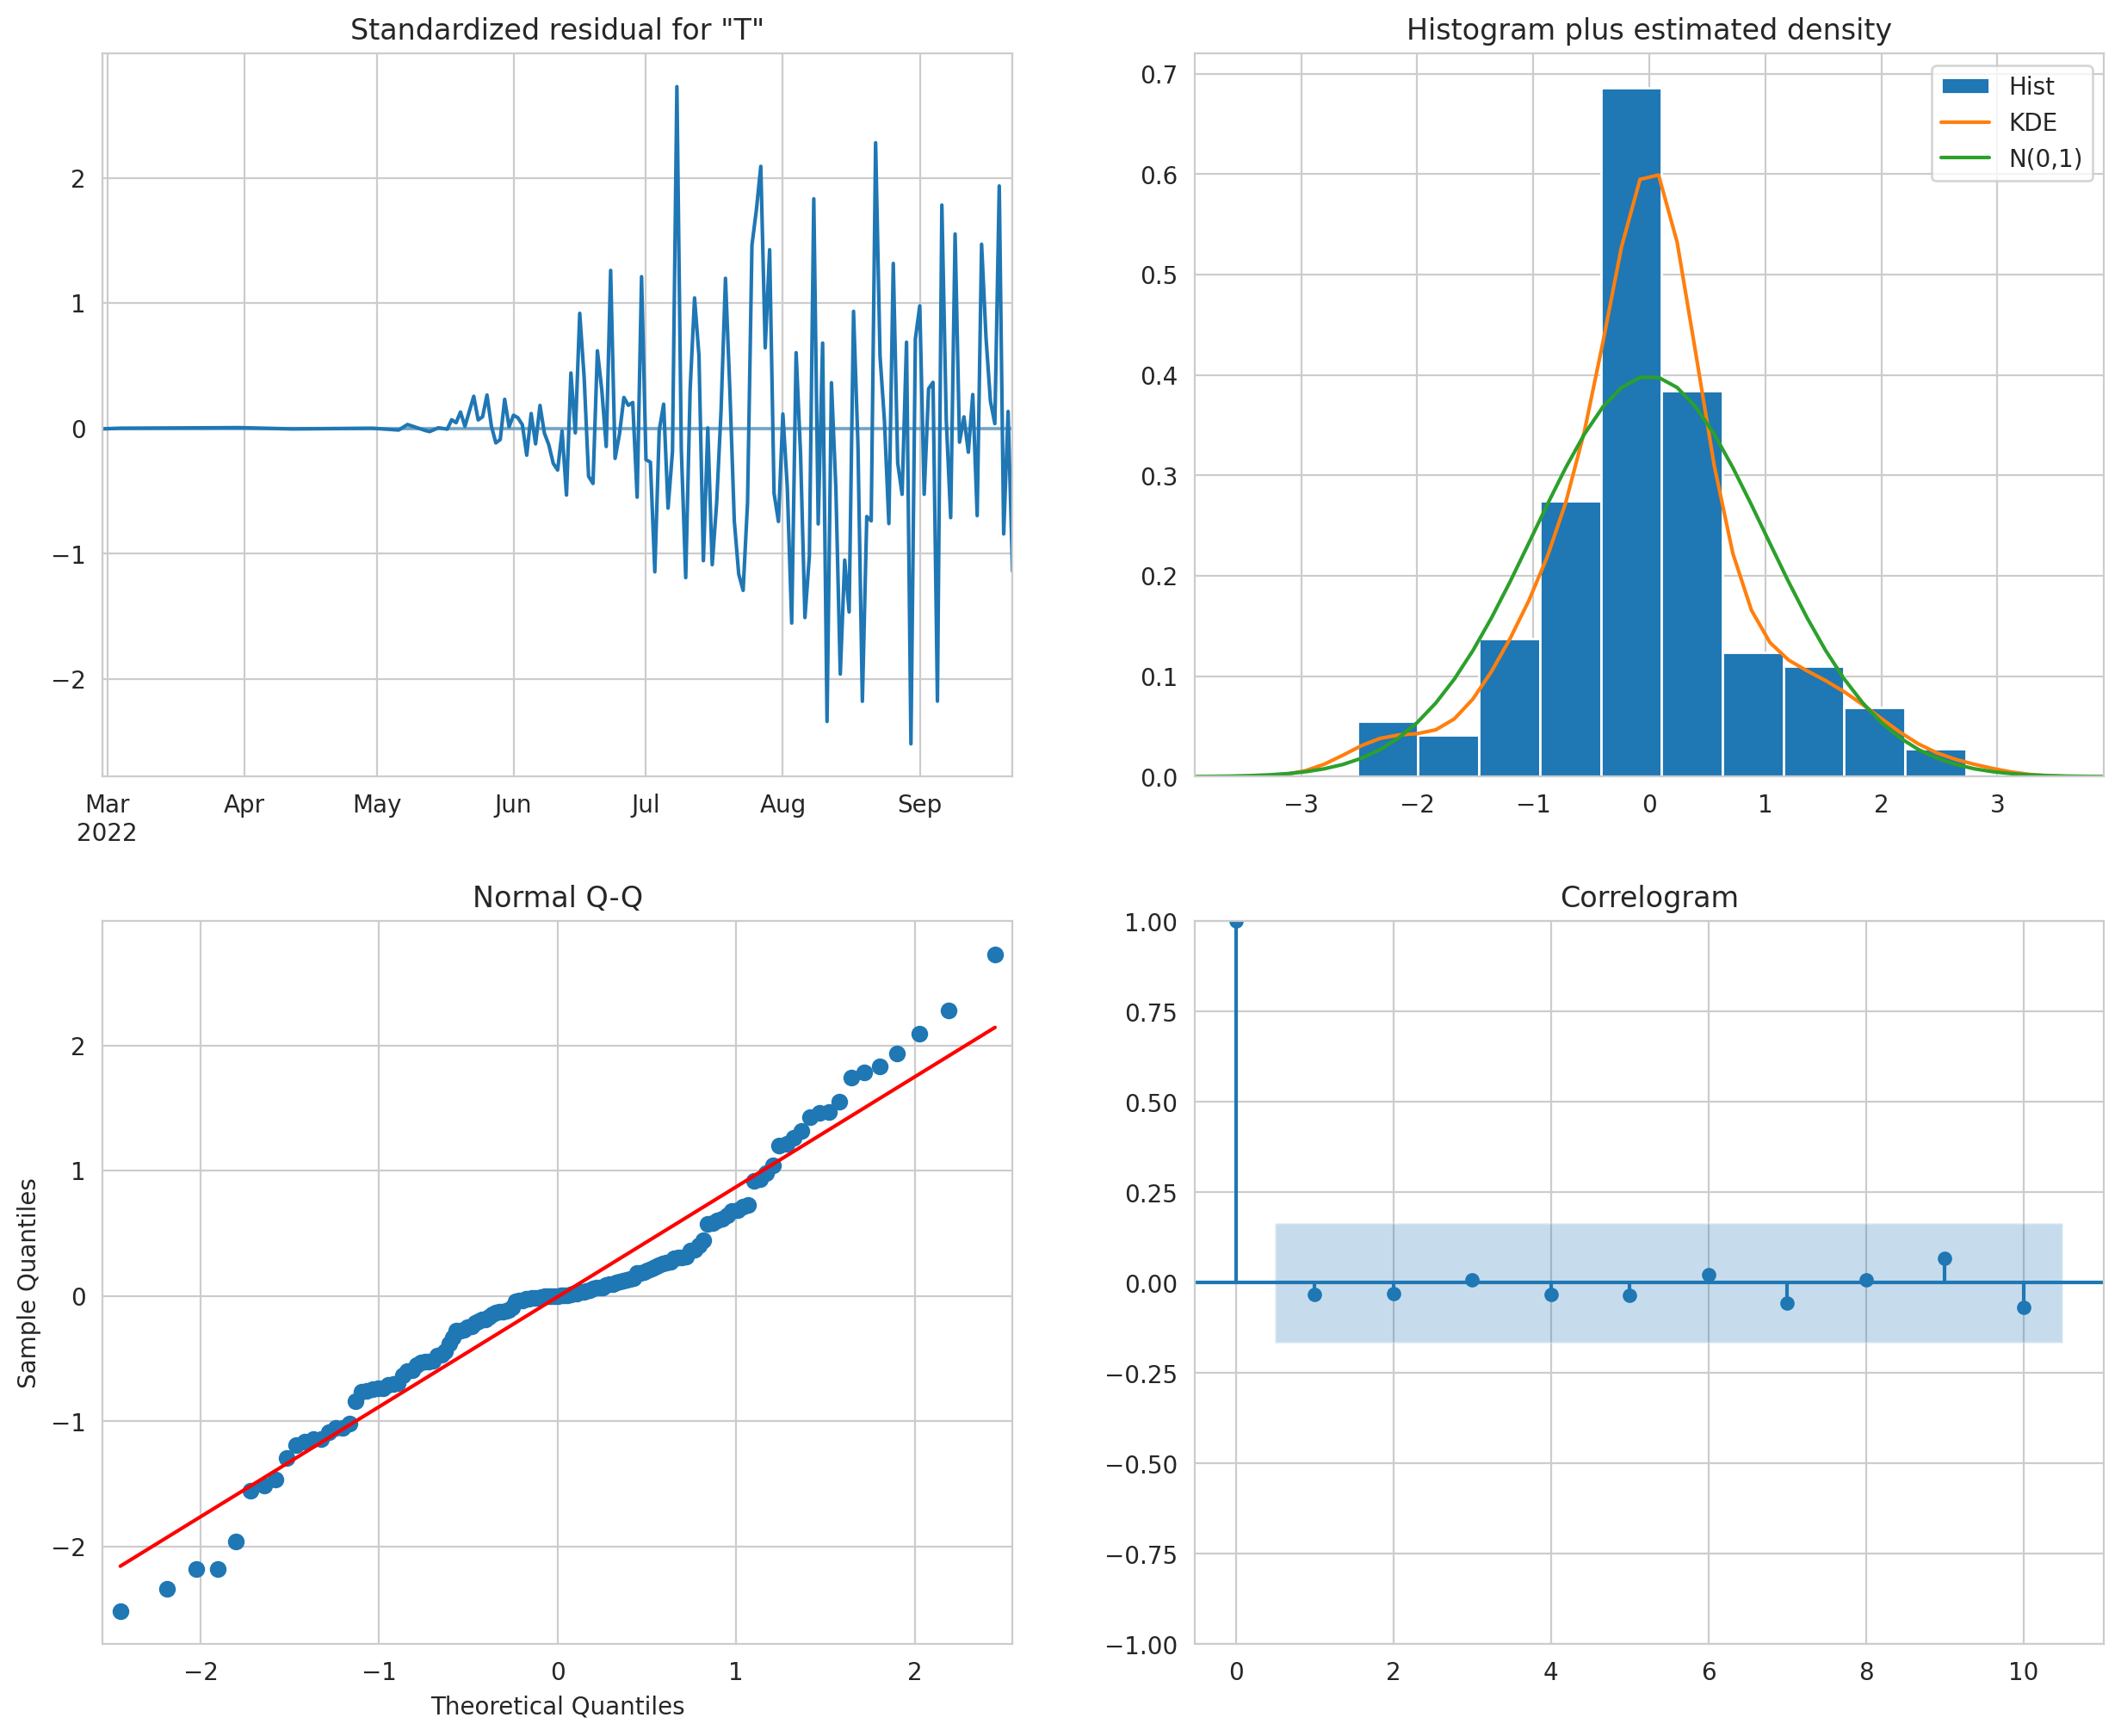

In [ ]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Testing the ARIMA model using the test dataset

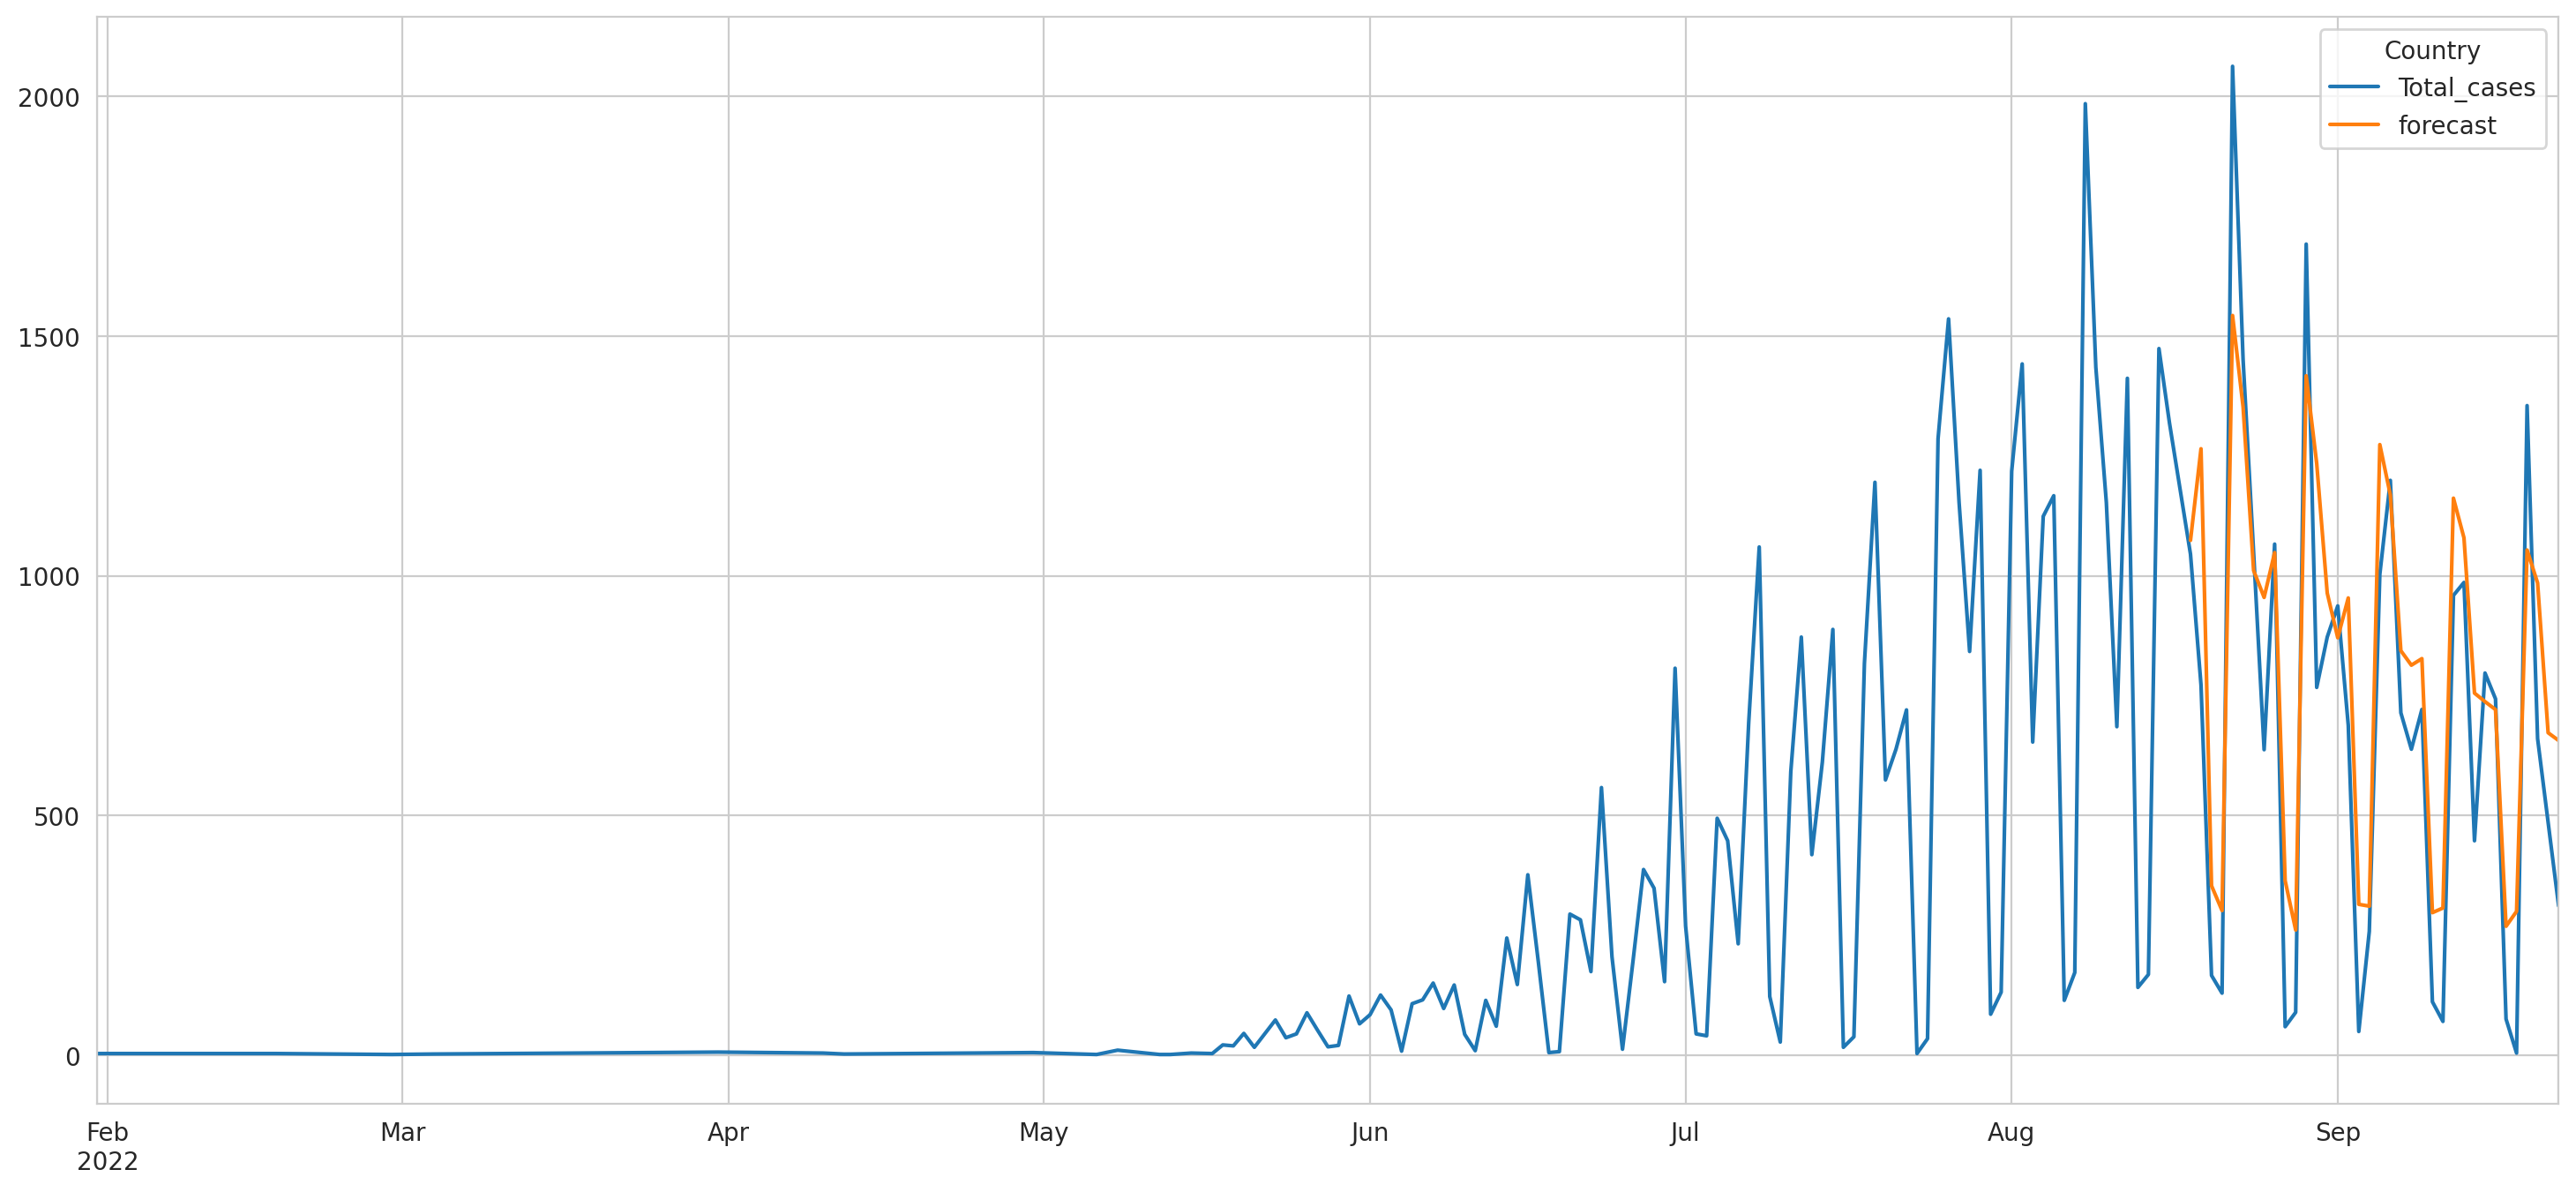

In [ ]:
start_index = test.index.min()
end_index = test.index.max()

daily_country_cases['forecast']=arima_model.predict(start=start_index,end=end_index,dynamic=True)
daily_country_cases[['Total_cases','forecast']].plot(figsize=(18,8))
plt.show()